# COVID-19 air pollution project. 
## Finding D value
### Written by Bujin Bekbulat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats as st
import scipy.io as sio
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.stats.multicomp as multi
import matplotlib.dates as md
import datetime
from math import sqrt
import plotly.graph_objects as go
%matplotlib inline
from scipy.stats import iqr
from statistics import median 
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [2]:
#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
#dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]


#Defining output
DF=pd.DataFrame()
Slope=pd.DataFrame()
OT=pd.DataFrame()
adjusted=[]
idw=[]
total_mon=0
DF5=pd.DataFrame()
Slope5=pd.DataFrame()
OT5=pd.DataFrame()
adjusted5=[]
idw5=[]
lastday=2
twoweeks=16
length=125
totallength=191



#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/COO.csv",parse_dates=['Date'], date_parser=dateparse)
    
a=[x for x in  list(set(Data['ID'])) if pd.notnull(x)] #each unique monitors in each state
total_mon=total_mon+len(a) #Counting total monitors

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
df5=pd.DataFrame()
slope15=pd.DataFrame()
ot5=pd.DataFrame()

    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       
       #Defining as variables
       #site=list(monitor['Site'])[0]     
       state=list(monitor['State'])[0] 
       idd=list(monitor['ID'])[0]
       county=list(monitor['County'])[0]
       lon=(list(monitor['Longitude'])[0])
       lat=(list(monitor['Latitude'])[0])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
       List5=[] 
       slope5=[]  

   
       #Starting filters
       
       #Days pre and post covid

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]

       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       print(whole)
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
          start_d = pd.to_datetime(start) + datetime.timedelta(j)
          end_d = start_d + datetime.timedelta(7)
         
          week=monitor[monitor['Date']>=start_d]
          week=week[week['Date']<end_d]
          if len(week)>0: 
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=month.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['County'],axis=1)
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


            # Will get a slope if it has more than 8 years of data
           if len(historical.columns)>=8:
                  
                  #10 year median 
                  Med=np.nanmedian(Historical_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend, intercept, r_value, p_value, std_err = st.linregress(x,y)
                  
                  #Adjusting historical median
                  adjusted_med =  trend * (len(historical.columns)+1)/2 + Med
                  if adjusted_med<0:
                    adjusted_med=0
                  #Calculating D value 
                  D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,trend,r_value**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted.append([idd,radians(lat),radians(lon),trend,"Week "+str(weeknum)])
                  slope.append(trend)
                  
                  
           else:

                  idw.append([idd,radians(lat),radians(lon)])
                
           if len(histfive.columns)>=4:
                  
                  #10 year median 
                  Med5=np.nanmedian(five_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend5, intercept, r_value5, p_value, std_err = st.linregress(x5,y5)
                  
                  #Adjusting historical median
                  adjusted_med5 =  trend5 * (len(histfive.columns)+1)/2 + Med5

                  #Calculating D value 
                  D_value5=(np.nanmedian(month['2020'])-adjusted_med5)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List5.append([D_value5,np.nanmedian(month['2020']),Med5,adjusted_med5,trend5,r_value5**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted5.append([idd,radians(lat),radians(lon),trend5,"Week "+str(weeknum)])
                  slope5.append(trend5)
                  
                  
           else:

                  idw5.append([idd,radians(lat),radians(lon)])

                  
                
        slope=pd.DataFrame(slope)
        slope5=pd.DataFrame(slope5)

        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
        if slope5.size>0:
           slope5.columns=[str(idd)]

         
        #Appending if it has 8 years of data
        if len(historical.columns)>=8:
          ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      
        if len(histfive.columns)>=4:
          ot5=pd.concat([ot5,monitor],axis=0,sort=False)
        slope15=pd.concat([slope15,slope5],axis=1,sort=False)   
        List5=pd.DataFrame(List5)
        df5=pd.concat([df5, List5], axis=0, sort=False)      


    #Concating for output
       
OT=pd.concat([OT,ot],axis=0,sort=False)
DF=pd.concat([DF, df], axis=0, sort=False)
Slope=pd.concat([Slope,slope1],axis=1,sort=False)
OT5=pd.concat([OT5,ot5],axis=0,sort=False)
DF5=pd.concat([DF5, df5], axis=0, sort=False)
Slope5=pd.concat([Slope5,slope15],axis=1,sort=False)

    






/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



            Date      2020      id                                 name  \
16590 2020-01-01  0.186250  4254.0  West Yellowstone Park Ent #2 AirNow   
16591 2020-01-02  0.175000  4254.0  West Yellowstone Park Ent #2 AirNow   
16592 2020-01-03  0.181250  4254.0  West Yellowstone Park Ent #2 AirNow   
16593 2020-01-04  0.215000  4254.0  West Yellowstone Park Ent #2 AirNow   
16594 2020-01-05  0.167500  4254.0  West Yellowstone Park Ent #2 AirNow   
...          ...       ...     ...                                  ...   
16830 2020-08-28  0.295000  4254.0  West Yellowstone Park Ent #2 AirNow   
16831 2020-08-29  0.282500  4254.0  West Yellowstone Park Ent #2 AirNow   
16832 2020-08-30  0.272500  4254.0  West Yellowstone Park Ent #2 AirNow   
16833 2020-08-31  0.227500  4254.0  West Yellowstone Park Ent #2 AirNow   
16834 2020-09-01  0.228571  4254.0  West Yellowstone Park Ent #2 AirNow   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018    State  \
16590    44.657    -111.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020       id          name  Latitude  Longitude  2019  \
26497 2020-01-01  0.225000  34182.0  NCORE AirNow    41.247    -95.973   0.2   
26498 2020-01-02  0.230000  34182.0  NCORE AirNow    41.247    -95.973   0.2   
26499 2020-01-03  0.350000  34182.0  NCORE AirNow    41.247    -95.973   0.3   
26500 2020-01-04  0.174286  34182.0  NCORE AirNow    41.247    -95.973   0.3   
26501 2020-01-05  0.143750  34182.0  NCORE AirNow    41.247    -95.973   0.3   
...          ...       ...      ...           ...       ...        ...   ...   
26737 2020-08-28  0.203750  34182.0  NCORE AirNow    41.247    -95.973   0.3   
26738 2020-08-29  0.261250  34182.0  NCORE AirNow    41.247    -95.973   0.2   
26739 2020-08-30  0.288750  34182.0  NCORE AirNow    41.247    -95.973   0.1   
26740 2020-08-31  0.183750  34182.0  NCORE AirNow    41.247    -95.973   0.1   
26741 2020-09-01  0.166250  34182.0  NCORE AirNow    41.247    -95.973   0.2   

       2014  2015  2016  2017  2018    

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id        name  Latitude  Longitude  2019  \
5394  2020-01-01  0.618750  2610.0  MLK AirNow    39.739    -75.558   0.2   
5395  2020-01-02  0.725000  2610.0  MLK AirNow    39.739    -75.558   0.3   
5396  2020-01-03  0.393333  2610.0  MLK AirNow    39.739    -75.558   0.3   
5397  2020-01-06  0.301250  2610.0  MLK AirNow    39.739    -75.558   0.2   
5398  2020-01-07  0.496250  2610.0  MLK AirNow    39.739    -75.558   0.2   
...          ...       ...     ...         ...       ...        ...   ...   
48210 2020-06-03       NaN     NaN         NaN    39.739    -75.558   0.3   
48211 2020-06-04       NaN     NaN         NaN    39.739    -75.558   0.2   
48212 2020-06-05       NaN     NaN         NaN    39.739    -75.558   0.2   
48213 2020-06-06       NaN     NaN         NaN    39.739    -75.558   0.3   
48214 2020-06-07       NaN     NaN         NaN    39.739    -75.558   0.3   

       2014  2015  2016  2017  2018     State         ID      County  2009 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
77358 2020-01-01   NaN NaN  NaN    40.801    -81.373   0.3   0.3   0.2   0.3   
77359 2020-01-02   NaN NaN  NaN    40.801    -81.373   0.3   0.3   0.5   0.3   
77360 2020-01-03   NaN NaN  NaN    40.801    -81.373   0.3   0.4   0.6   0.3   
77361 2020-01-04   NaN NaN  NaN    40.801    -81.373   0.3   0.4   0.3   0.3   
77362 2020-01-05   NaN NaN  NaN    40.801    -81.373   0.4   0.5   0.3   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
77598 2020-08-28   NaN NaN  NaN    40.801    -81.373   NaN   0.4   0.4   0.6   
77599 2020-08-29   NaN NaN  NaN    40.801    -81.373   NaN   0.4   0.4   0.6   
77600 2020-08-30   NaN NaN  NaN    40.801    -81.373   NaN   0.4   0.4   0.6   
77601 2020-08-31   NaN NaN  NaN    40.801    -81.373   NaN   0.4   0.5   0.6   
77602 2020-09-01   NaN NaN  NaN    40.801    -81.373   NaN   0.4   0.6   0.5   

       2017  2018 State         ID Coun

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



           Date     2020      id            name  Latitude  Longitude  2019  \
1025 2020-01-01  1.04125  2342.0  Oakland AirNow    37.743    -122.17   0.4   
1026 2020-01-02  0.62875  2342.0  Oakland AirNow    37.743    -122.17   0.6   
1027 2020-01-03  0.82250  2342.0  Oakland AirNow    37.743    -122.17   0.6   
1028 2020-01-04  0.84875  2342.0  Oakland AirNow    37.743    -122.17   0.7   
1029 2020-01-05  0.73625  2342.0  Oakland AirNow    37.743    -122.17   0.6   
...         ...      ...     ...             ...       ...        ...   ...   
1265 2020-08-28  0.77000  2342.0  Oakland AirNow    37.743    -122.17   0.4   
1266 2020-08-29  0.51625  2342.0  Oakland AirNow    37.743    -122.17   0.3   
1267 2020-08-30  0.42125  2342.0  Oakland AirNow    37.743    -122.17   0.4   
1268 2020-08-31  0.58250  2342.0  Oakland AirNow    37.743    -122.17   0.5   
1269 2020-09-01  0.51625  2342.0  Oakland AirNow    37.743    -122.17   0.5   

      2014  2015  2016  2017  2018       State     

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
57443 2020-01-01   NaN NaN  NaN    30.462    -91.179   0.2   0.3   0.2   0.2   
57444 2020-01-02   NaN NaN  NaN    30.462    -91.179   0.2   0.3   0.3   0.2   
57445 2020-01-03   NaN NaN  NaN    30.462    -91.179   0.3   0.3   0.2   0.3   
57446 2020-01-04   NaN NaN  NaN    30.462    -91.179   0.2   0.3   0.2   0.3   
57447 2020-01-05   NaN NaN  NaN    30.462    -91.179   0.6   0.3   0.4   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
57683 2020-08-28   NaN NaN  NaN    30.462    -91.179   0.1   0.4   0.3   0.2   
57684 2020-08-29   NaN NaN  NaN    30.462    -91.179   0.4   0.4   0.5   0.2   
57685 2020-08-30   NaN NaN  NaN    30.462    -91.179   0.5   0.3   0.3   0.4   
57686 2020-08-31   NaN NaN  NaN    30.462    -91.179   0.6   0.3   0.4   0.5   
57687 2020-09-01   NaN NaN  NaN    30.462    -91.179   0.2   0.3   0.3   0.2   

       2017  2018      State         ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id                  name  Latitude  Longitude  \
15564 2020-01-01  0.884286  4203.0  Laney College AirNow    37.794   -122.263   
15565 2020-01-02  0.664286  4203.0  Laney College AirNow    37.794   -122.263   
15566 2020-01-03  0.830000  4203.0  Laney College AirNow    37.794   -122.263   
15567 2020-01-04  0.687500  4203.0  Laney College AirNow    37.794   -122.263   
15568 2020-01-05  0.723750  4203.0  Laney College AirNow    37.794   -122.263   
...          ...       ...     ...                   ...       ...        ...   
15804 2020-08-28  0.876250  4203.0  Laney College AirNow    37.794   -122.263   
15805 2020-08-29  0.466250  4203.0  Laney College AirNow    37.794   -122.263   
15806 2020-08-30  0.471250  4203.0  Laney College AirNow    37.794   -122.263   
15807 2020-08-31  0.590000  4203.0  Laney College AirNow    37.794   -122.263   
15808 2020-09-01  0.482500  4203.0  Laney College AirNow    37.794   -122.263   

       2019  2014  2015  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id                          name  Latitude  \
18380 2020-01-01  0.670000  7072.0  Berkeley Aquatic Park AirNow    37.865   
18381 2020-01-02  0.818750  7072.0  Berkeley Aquatic Park AirNow    37.865   
18382 2020-01-03  0.997143  7072.0  Berkeley Aquatic Park AirNow    37.865   
18383 2020-01-04  0.821250  7072.0  Berkeley Aquatic Park AirNow    37.865   
18384 2020-01-05  0.698571  7072.0  Berkeley Aquatic Park AirNow    37.865   
...          ...       ...     ...                           ...       ...   
18619 2020-08-28  0.832500  7072.0  Berkeley Aquatic Park AirNow    37.865   
18620 2020-08-29  0.483750  7072.0  Berkeley Aquatic Park AirNow    37.865   
18621 2020-08-30  0.380000  7072.0  Berkeley Aquatic Park AirNow    37.865   
18622 2020-08-31  0.645000  7072.0  Berkeley Aquatic Park AirNow    37.865   
18623 2020-09-01  0.465000  7072.0  Berkeley Aquatic Park AirNow    37.865   

       Longitude  2019  2014  2015  2016  2017  2018       Stat

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
29124 2020-01-01   NaN NaN  NaN    33.521    -86.844   0.3   0.7   0.5   0.3   
29125 2020-01-02   NaN NaN  NaN    33.521    -86.844   0.3   0.4   0.5   0.8   
29126 2020-01-03   NaN NaN  NaN    33.521    -86.844   0.4   0.3   0.4   1.0   
29127 2020-01-04   NaN NaN  NaN    33.521    -86.844   0.4   0.5   0.3   0.5   
29128 2020-01-05   NaN NaN  NaN    33.521    -86.844   1.0   0.4   0.5   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
29364 2020-08-28   NaN NaN  NaN    33.521    -86.844   NaN   0.9   0.5   0.8   
29365 2020-08-29   NaN NaN  NaN    33.521    -86.844   NaN   0.6   0.5   0.5   
29366 2020-08-30   NaN NaN  NaN    33.521    -86.844   NaN   0.6   0.4   0.4   
29367 2020-08-31   NaN NaN  NaN    33.521    -86.844   NaN   0.7   0.6   0.5   
29368 2020-09-01   NaN NaN  NaN    33.521    -86.844   NaN   0.8   0.7   0.6   

       2017  2018    State        ID   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id             name  Latitude  Longitude  \
22916 2020-01-01  0.97125  34110.0  Pasadena AirNow    34.133   -118.127   
22917 2020-01-02  0.75750  34110.0  Pasadena AirNow    34.133   -118.127   
22918 2020-01-03  0.82500  34110.0  Pasadena AirNow    34.133   -118.127   
22919 2020-01-04  0.93375  34110.0  Pasadena AirNow    34.133   -118.127   
22920 2020-01-05  0.86500  34110.0  Pasadena AirNow    34.133   -118.127   
...          ...      ...      ...              ...       ...        ...   
23156 2020-08-29  0.30875  34110.0  Pasadena AirNow    34.133   -118.127   
23157 2020-08-30  0.23875  34110.0  Pasadena AirNow    34.133   -118.127   
23158 2020-08-31  0.28250  34110.0  Pasadena AirNow    34.133   -118.127   
23159 2020-09-01  0.26750  34110.0  Pasadena AirNow    34.133   -118.127   
37099 2020-04-26      NaN      NaN              NaN    34.133   -118.127   

       2019  2014  2015  2016  2017  2018       State        ID       County  \
22916  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
32584 2020-01-01   NaN NaN  NaN    32.207   -110.911   0.1   0.5   0.4   0.5   
32585 2020-01-02   NaN NaN  NaN    32.207   -110.911   0.3   0.7   0.7   0.4   
32586 2020-01-03   NaN NaN  NaN    32.207   -110.911   0.5   0.7   0.8   0.4   
32587 2020-01-04   NaN NaN  NaN    32.207   -110.911   0.6   0.6   0.7   0.4   
32588 2020-01-05   NaN NaN  NaN    32.207   -110.911   0.6   0.7   0.6   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
32824 2020-08-28   NaN NaN  NaN    32.207   -110.911   0.3   0.5   0.3   0.2   
32825 2020-08-29   NaN NaN  NaN    32.207   -110.911   0.3   0.6   0.3   0.3   
32826 2020-08-30   NaN NaN  NaN    32.207   -110.911   0.3   0.5   NaN   0.3   
32827 2020-08-31   NaN NaN  NaN    32.207   -110.911   0.2   NaN   0.2   0.3   
32828 2020-09-01   NaN NaN  NaN    32.207   -110.911   0.2   NaN   0.3   0.3   

       2017  2018    State        ID Co

            Date      2020       id                               name  \
25988 2020-01-01  0.261429  34151.0  New Haven - Criscuolo Park AirNow   
25989 2020-01-02  0.296250  34151.0  New Haven - Criscuolo Park AirNow   
25990 2020-01-03  0.610000  34151.0  New Haven - Criscuolo Park AirNow   
25991 2020-01-04  0.660000  34151.0  New Haven - Criscuolo Park AirNow   
25992 2020-01-05  0.264286  34151.0  New Haven - Criscuolo Park AirNow   
...          ...       ...      ...                                ...   
26228 2020-08-28  0.275714  34151.0  New Haven - Criscuolo Park AirNow   
26229 2020-08-29  0.222857  34151.0  New Haven - Criscuolo Park AirNow   
26230 2020-08-30  0.236250  34151.0  New Haven - Criscuolo Park AirNow   
26231 2020-08-31  0.292857  34151.0  New Haven - Criscuolo Park AirNow   
26232 2020-09-01  0.144286  34151.0  New Haven - Criscuolo Park AirNow   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018        State  \
25988    41.301    -72.903   0.2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
80247 2020-01-01   NaN NaN  NaN    41.443    -75.623   0.2   0.2   0.0   0.2   
80248 2020-01-02   NaN NaN  NaN    41.443    -75.623   0.2   0.2   0.0   0.2   
80249 2020-01-03   NaN NaN  NaN    41.443    -75.623   0.2   0.3   0.0   0.3   
80250 2020-01-04   NaN NaN  NaN    41.443    -75.623   0.5   0.6   0.0   0.2   
80251 2020-01-05   NaN NaN  NaN    41.443    -75.623   0.6   0.6   0.0   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
80487 2020-08-28   NaN NaN  NaN    41.443    -75.623   0.2   0.4   0.5   0.5   
80488 2020-08-29   NaN NaN  NaN    41.443    -75.623   0.3   0.4   0.6   0.4   
80489 2020-08-30   NaN NaN  NaN    41.443    -75.623   0.3   0.4   0.6   0.4   
80490 2020-08-31   NaN NaN  NaN    41.443    -75.623   0.4   0.7   0.6   0.4   
80491 2020-09-01   NaN NaN  NaN    41.443    -75.623   0.3   0.8   0.6   0.4   

       2017  2018         State        

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date    2020      id                  name  Latitude  Longitude  \
17106 2020-01-01  0.6125  4571.0  Near Road OKC AirNow    35.503    -97.578   
17107 2020-01-02  0.7625  4571.0  Near Road OKC AirNow    35.503    -97.578   
17108 2020-01-03  0.5125  4571.0  Near Road OKC AirNow    35.503    -97.578   
17109 2020-01-04  0.7375  4571.0  Near Road OKC AirNow    35.503    -97.578   
17110 2020-01-05  0.6625  4571.0  Near Road OKC AirNow    35.503    -97.578   
...          ...     ...     ...                   ...       ...        ...   
17346 2020-08-30  0.7000  4571.0  Near Road OKC AirNow    35.503    -97.578   
17347 2020-08-31  0.6125  4571.0  Near Road OKC AirNow    35.503    -97.578   
17348 2020-09-01  0.6875  4571.0  Near Road OKC AirNow    35.503    -97.578   
78456 2020-03-09     NaN     NaN                   NaN    35.503    -97.578   
78457 2020-03-10     NaN     NaN                   NaN    35.503    -97.578   

       2019  2014  2015  2016  2017  2018     State

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
32218 2020-01-01   NaN NaN  NaN    32.295   -110.982   0.2   0.5   0.2   0.6   
32219 2020-01-02   NaN NaN  NaN    32.295   -110.982   0.4   0.5   0.4   0.5   
32220 2020-01-03   NaN NaN  NaN    32.295   -110.982   0.4   0.4   0.5   0.4   
32221 2020-01-04   NaN NaN  NaN    32.295   -110.982   0.4   0.6   0.6   0.4   
32222 2020-01-05   NaN NaN  NaN    32.295   -110.982   0.5   0.7   0.5   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
32458 2020-08-28   NaN NaN  NaN    32.295   -110.982   0.1   0.2   0.2   0.2   
32459 2020-08-29   NaN NaN  NaN    32.295   -110.982   0.2   0.2   0.2   0.2   
32460 2020-08-30   NaN NaN  NaN    32.295   -110.982   0.1   0.2   0.2   0.2   
32461 2020-08-31   NaN NaN  NaN    32.295   -110.982   0.1   0.2   0.1   0.2   
32462 2020-09-01   NaN NaN  NaN    32.295   -110.982   0.1   0.2   0.2   0.2   

       2017  2018    State        ID Co

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



           Date      2020      id                                name  \
3587 2020-01-01  0.550000  2454.0  Sacramento - Del Paso Manor AirNow   
3588 2020-01-02  0.526250  2454.0  Sacramento - Del Paso Manor AirNow   
3589 2020-01-03  0.737500  2454.0  Sacramento - Del Paso Manor AirNow   
3590 2020-01-04  0.766250  2454.0  Sacramento - Del Paso Manor AirNow   
3591 2020-01-05  0.664286  2454.0  Sacramento - Del Paso Manor AirNow   
...         ...       ...     ...                                 ...   
3827 2020-08-28  0.458750  2454.0  Sacramento - Del Paso Manor AirNow   
3828 2020-08-29  0.427500  2454.0  Sacramento - Del Paso Manor AirNow   
3829 2020-08-30  0.546250  2454.0  Sacramento - Del Paso Manor AirNow   
3830 2020-08-31  0.523333  2454.0  Sacramento - Del Paso Manor AirNow   
3831 2020-09-01  0.420000  2454.0  Sacramento - Del Paso Manor AirNow   

      Latitude  Longitude  2019  2014  2015  2016  2017  2018       State  \
3587    38.614   -121.368   0.2   1.1   1.3   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

invalid value encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
36039 2020-01-01   NaN NaN  NaN    38.712   -121.381   0.3   1.1   0.9   1.1   
36040 2020-01-02   NaN NaN  NaN    38.712   -121.381   0.9   0.9   1.0   1.2   
36041 2020-01-03   NaN NaN  NaN    38.712   -121.381   0.9   0.9   1.2   0.6   
36042 2020-01-04   NaN NaN  NaN    38.712   -121.381   1.2   0.8   1.1   0.9   
36043 2020-01-05   NaN NaN  NaN    38.712   -121.381   1.0   0.8   1.3   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
36279 2020-08-28   NaN NaN  NaN    38.712   -121.381   NaN   0.3   0.2   0.5   
36280 2020-08-29   NaN NaN  NaN    38.712   -121.381   NaN   0.3   0.2   0.5   
36281 2020-08-30   NaN NaN  NaN    38.712   -121.381   NaN   0.3   0.2   0.5   
36282 2020-08-31   NaN NaN  NaN    38.712   -121.381   NaN   0.3   0.3   0.5   
36283 2020-09-01   NaN NaN  NaN    38.712   -121.381   NaN   0.4   0.3   0.5   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
83696 2020-01-01   NaN NaN  NaN    43.548    -96.701   0.2   0.2   0.4   0.2   
83697 2020-01-02   NaN NaN  NaN    43.548    -96.701   0.2   0.3   0.4   0.2   
83698 2020-01-03   NaN NaN  NaN    43.548    -96.701   0.2   0.2   0.2   0.2   
83699 2020-01-04   NaN NaN  NaN    43.548    -96.701   0.3   0.2   0.2   0.2   
83700 2020-01-05   NaN NaN  NaN    43.548    -96.701   0.3   0.2   0.3   0.2   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
83936 2020-08-28   NaN NaN  NaN    43.548    -96.701   0.3   0.2   0.2   0.2   
83937 2020-08-29   NaN NaN  NaN    43.548    -96.701   0.2   0.3   0.2   0.2   
83938 2020-08-30   NaN NaN  NaN    43.548    -96.701   0.3   0.3   0.2   0.2   
83939 2020-08-31   NaN NaN  NaN    43.548    -96.701   0.2   0.2   0.2   0.2   
83940 2020-09-01   NaN NaN  NaN    43.548    -96.701   0.2   0.2   0.3   0.3   

       2017  2018         State        

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id                             name  Latitude  \
10452 2020-01-01  0.263750  3432.0  STILWELL CASTNET & NCORE AirNow    35.751   
10453 2020-01-02  0.228571  3432.0  STILWELL CASTNET & NCORE AirNow    35.751   
10454 2020-01-03  0.273750  3432.0  STILWELL CASTNET & NCORE AirNow    35.751   
10455 2020-01-04  0.181429  3432.0  STILWELL CASTNET & NCORE AirNow    35.751   
10456 2020-01-05  0.320000  3432.0  STILWELL CASTNET & NCORE AirNow    35.751   
...          ...       ...     ...                              ...       ...   
79002 2020-07-10       NaN     NaN                              NaN    35.751   
79003 2020-07-11       NaN     NaN                              NaN    35.751   
79004 2020-07-12       NaN     NaN                              NaN    35.751   
79005 2020-07-13       NaN     NaN                              NaN    35.751   
79006 2020-07-14       NaN     NaN                              NaN    35.751   

       Longitude  2019  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
54666 2020-01-01   NaN NaN  NaN    37.978    -87.597   0.3   0.1   0.1   0.2   
54667 2020-01-02   NaN NaN  NaN    37.978    -87.597   0.4   0.5   1.0   0.4   
54668 2020-01-03   NaN NaN  NaN    37.978    -87.597   0.6   1.0   0.3   0.4   
54669 2020-01-04   NaN NaN  NaN    37.978    -87.597   0.5   0.5   0.1   0.2   
54670 2020-01-05   NaN NaN  NaN    37.978    -87.597   0.3   0.1   0.4   0.6   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
54906 2020-08-28   NaN NaN  NaN    37.978    -87.597   0.4   0.5   0.2   0.5   
54907 2020-08-29   NaN NaN  NaN    37.978    -87.597   0.4   0.4   0.3   0.4   
54908 2020-08-30   NaN NaN  NaN    37.978    -87.597   0.6   0.2   0.3   0.4   
54909 2020-08-31   NaN NaN  NaN    37.978    -87.597   0.6   0.1   0.1   0.3   
54910 2020-09-01   NaN NaN  NaN    37.978    -87.597   0.5   0.1   0.2   0.2   

       2017  2018    State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
89184 2020-01-01   NaN NaN  NaN     32.82     -96.86   0.1   0.2   0.3   0.3   
89185 2020-01-02   NaN NaN  NaN     32.82     -96.86   0.2   0.5   0.3   0.3   
89186 2020-01-03   NaN NaN  NaN     32.82     -96.86   0.2   0.9   0.4   0.4   
89187 2020-01-04   NaN NaN  NaN     32.82     -96.86   0.9   0.2   0.4   0.4   
89188 2020-01-05   NaN NaN  NaN     32.82     -96.86   1.2   0.2   0.3   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
89424 2020-08-28   NaN NaN  NaN     32.82     -96.86   0.2   0.4   0.3   0.2   
89425 2020-08-29   NaN NaN  NaN     32.82     -96.86   0.2   0.2   0.3   0.4   
89426 2020-08-30   NaN NaN  NaN     32.82     -96.86   0.2   0.2   0.3   0.3   
89427 2020-08-31   NaN NaN  NaN     32.82     -96.86   0.2   0.2   0.3   0.3   
89428 2020-09-01   NaN NaN  NaN     32.82     -96.86   0.2   0.1   0.2   0.3   

       2017  2018  State         ID  Co

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
88452 2020-01-01   NaN NaN  NaN    31.653    -97.071   0.1   0.2   0.2   0.1   
88453 2020-01-02   NaN NaN  NaN    31.653    -97.071   0.2   0.1   0.2   0.2   
88454 2020-01-03   NaN NaN  NaN    31.653    -97.071   0.2   0.2   0.2   0.2   
88455 2020-01-04   NaN NaN  NaN    31.653    -97.071   0.2   0.1   0.2   0.2   
88456 2020-01-05   NaN NaN  NaN    31.653    -97.071   0.3   0.1   0.2   0.1   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
88692 2020-08-28   NaN NaN  NaN    31.653    -97.071   0.3   0.1   0.2   0.3   
88693 2020-08-29   NaN NaN  NaN    31.653    -97.071   0.2   0.1   0.2   0.2   
88694 2020-08-30   NaN NaN  NaN    31.653    -97.071   0.2   0.1   0.2   0.3   
88695 2020-08-31   NaN NaN  NaN    31.653    -97.071   0.2   0.1   0.2   0.3   
88696 2020-09-01   NaN NaN  NaN    31.653    -97.071   0.3   0.1   0.1   0.3   

       2017  2018  State         ID    

            Date      2020      id                    name  Latitude  \
13998 2020-01-01  0.035000  4118.0  Indpls - I-70 E AirNow    39.788   
13999 2020-01-02  0.048333  4118.0  Indpls - I-70 E AirNow    39.788   
14000 2020-01-03  0.255000  4118.0  Indpls - I-70 E AirNow    39.788   
14001 2020-01-04  0.135000  4118.0  Indpls - I-70 E AirNow    39.788   
14002 2020-01-05  0.040000  4118.0  Indpls - I-70 E AirNow    39.788   
...          ...       ...     ...                     ...       ...   
53821 2020-08-02       NaN     NaN                     NaN    39.788   
53822 2020-08-03       NaN     NaN                     NaN    39.788   
53823 2020-08-04       NaN     NaN                     NaN    39.788   
53824 2020-08-05       NaN     NaN                     NaN    39.788   
53825 2020-08-06       NaN     NaN                     NaN    39.788   

       Longitude  2019  2014  2015  2016  2017  2018    State         ID  \
13998    -86.131   NaN   NaN   0.2   NaN   1.0   0.3  India

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
43203 2020-01-01   NaN NaN  NaN    34.894   -117.025   0.3   0.7   0.5   0.5   
43204 2020-01-02   NaN NaN  NaN    34.894   -117.025   0.3   0.4   0.5   0.4   
43205 2020-01-03   NaN NaN  NaN    34.894   -117.025   0.3   0.4   0.5   0.3   
43206 2020-01-04   NaN NaN  NaN    34.894   -117.025   0.3   0.4   0.6   0.4   
43207 2020-01-05   NaN NaN  NaN    34.894   -117.025   0.3   0.4   0.4   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
43443 2020-08-28   NaN NaN  NaN    34.894   -117.025   0.1   0.4   NaN   0.2   
43444 2020-08-29   NaN NaN  NaN    34.894   -117.025   0.1   0.4   NaN   0.2   
43445 2020-08-30   NaN NaN  NaN    34.894   -117.025   0.1   0.4   NaN   0.2   
43446 2020-08-31   NaN NaN  NaN    34.894   -117.025   0.2   0.4   NaN   0.2   
43447 2020-09-01   NaN NaN  NaN    34.894   -117.025   0.2   0.4   NaN   0.2   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id              name  Latitude  Longitude  \
9453  2020-01-01  0.375000  3221.0  Elizabeth AirNow    40.662    -74.215   
9454  2020-01-02  0.571429  3221.0  Elizabeth AirNow    40.662    -74.215   
9455  2020-01-03  0.628571  3221.0  Elizabeth AirNow    40.662    -74.215   
9456  2020-01-04  0.757143  3221.0  Elizabeth AirNow    40.662    -74.215   
9457  2020-01-05  0.300000  3221.0  Elizabeth AirNow    40.662    -74.215   
...          ...       ...     ...               ...       ...        ...   
9693  2020-08-29  0.428571  3221.0  Elizabeth AirNow    40.662    -74.215   
9694  2020-08-30  0.428571  3221.0  Elizabeth AirNow    40.662    -74.215   
9695  2020-08-31  0.512500  3221.0  Elizabeth AirNow    40.662    -74.215   
9696  2020-09-01  0.525000  3221.0  Elizabeth AirNow    40.662    -74.215   
68006 2020-02-25       NaN     NaN               NaN    40.662    -74.215   

       2019  2014  2015  2016  2017  2018       State         ID County  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id                      name  Latitude  \
9710  2020-01-01  0.200000  3222.0  Elizabeth Trailer AirNow    40.641   
9711  2020-01-02  0.528571  3222.0  Elizabeth Trailer AirNow    40.641   
9712  2020-01-03  0.412500  3222.0  Elizabeth Trailer AirNow    40.641   
9713  2020-01-04  0.457143  3222.0  Elizabeth Trailer AirNow    40.641   
9714  2020-01-05  0.237500  3222.0  Elizabeth Trailer AirNow    40.641   
...          ...       ...     ...                       ...       ...   
69098 2020-07-24       NaN     NaN                       NaN    40.641   
69099 2020-07-25       NaN     NaN                       NaN    40.641   
69100 2020-07-26       NaN     NaN                       NaN    40.641   
69101 2020-07-27       NaN     NaN                       NaN    40.641   
69102 2020-07-28       NaN     NaN                       NaN    40.641   

       Longitude  2019  2014  2015  2016  2017  2018       State         ID  \
9710     -74.208   0.3   0.6   0

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
68115 2020-01-01   NaN NaN  NaN    39.935    -75.125   0.4   0.2   0.4   0.1   
68116 2020-01-02   NaN NaN  NaN    39.935    -75.125   0.5   0.3   0.6   0.4   
68117 2020-01-03   NaN NaN  NaN    39.935    -75.125   0.2   0.3   0.9   0.6   
68118 2020-01-04   NaN NaN  NaN    39.935    -75.125   0.3   0.5   0.5   0.2   
68119 2020-01-05   NaN NaN  NaN    39.935    -75.125   0.3   0.9   0.4   0.7   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
68355 2020-08-28   NaN NaN  NaN    39.935    -75.125   0.2   0.3   0.3   0.2   
68356 2020-08-29   NaN NaN  NaN    39.935    -75.125   0.2   0.2   0.4   0.2   
68357 2020-08-30   NaN NaN  NaN    39.935    -75.125   0.3   0.2   0.2   0.2   
68358 2020-08-31   NaN NaN  NaN    39.935    -75.125   0.3   0.2   0.3   0.2   
68359 2020-09-01   NaN NaN  NaN    39.935    -75.125   0.3   0.2   0.3   0.2   

       2017  2018       State         I

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date     2020      id         name  Latitude  Longitude  2019  \
10205 2020-01-01  0.17500  3391.0  Taft AirNow    39.129    -84.504   0.2   
10206 2020-01-02  0.25875  3391.0  Taft AirNow    39.129    -84.504   0.3   
10207 2020-01-03  0.31750  3391.0  Taft AirNow    39.129    -84.504   0.4   
10208 2020-01-04  0.19000  3391.0  Taft AirNow    39.129    -84.504   0.5   
10209 2020-01-05  0.16000  3391.0  Taft AirNow    39.129    -84.504   0.2   
...          ...      ...     ...          ...       ...        ...   ...   
76639 2020-02-18      NaN     NaN          NaN    39.129    -84.504   0.2   
76640 2020-02-19      NaN     NaN          NaN    39.129    -84.504   0.4   
76641 2020-02-20      NaN     NaN          NaN    39.129    -84.504   0.3   
76642 2020-04-18      NaN     NaN          NaN    39.129    -84.504   0.2   
76643 2020-04-19      NaN     NaN          NaN    39.129    -84.504   0.2   

       2014  2015  2016  2017  2018 State         ID    County  2009  2010 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id             name  Latitude  Longitude  \
10709 2020-01-02  0.284286  3588.0  Parklane AirNow    34.094    -80.962   
10710 2020-01-03  0.175000  3588.0  Parklane AirNow    34.094    -80.962   
10711 2020-01-04  0.010000  3588.0  Parklane AirNow    34.094    -80.962   
10712 2020-01-06  0.377143  3588.0  Parklane AirNow    34.094    -80.962   
10713 2020-01-07  0.375714  3588.0  Parklane AirNow    34.094    -80.962   
...          ...       ...     ...              ...       ...        ...   
83582 2020-07-31       NaN     NaN              NaN    34.094    -80.962   
83583 2020-08-01       NaN     NaN              NaN    34.094    -80.962   
83584 2020-08-02       NaN     NaN              NaN    34.094    -80.962   
83585 2020-08-04       NaN     NaN              NaN    34.094    -80.962   
83586 2020-08-29       NaN     NaN              NaN    34.094    -80.962   

       2019  2014  2015  2016  2017  2018           State         ID  \
10709   0.2   0

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
64376 2020-01-01   NaN NaN  NaN    44.776    -93.063   0.2   0.0   0.1   0.0   
64377 2020-01-02   NaN NaN  NaN    44.776    -93.063   0.2   0.1   0.1   0.0   
64378 2020-01-03   NaN NaN  NaN    44.776    -93.063   0.4   0.1   0.1   0.0   
64379 2020-01-04   NaN NaN  NaN    44.776    -93.063   0.4   0.0   0.0   0.1   
64380 2020-01-05   NaN NaN  NaN    44.776    -93.063   0.3   0.0   0.0   0.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
64616 2020-08-28   NaN NaN  NaN    44.776    -93.063   0.1   0.0   0.0   NaN   
64617 2020-08-29   NaN NaN  NaN    44.776    -93.063   0.1   0.0   0.1   NaN   
64618 2020-08-30   NaN NaN  NaN    44.776    -93.063   0.1   0.0   0.0   NaN   
64619 2020-08-31   NaN NaN  NaN    44.776    -93.063   0.1   0.0   0.0   NaN   
64620 2020-09-01   NaN NaN  NaN    44.776    -93.063   0.1   0.0   0.0   NaN   

       2017  2018      State         ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id        name  Latitude  Longitude  2019  \
13727 2020-01-01  0.455714  4113.0  NEW AirNow    39.991    -75.081   0.1   
13728 2020-01-02  0.485000  4113.0  NEW AirNow    39.991    -75.081   0.3   
13729 2020-01-03  0.268571  4113.0  NEW AirNow    39.991    -75.081   0.3   
13730 2020-01-04  0.281250  4113.0  NEW AirNow    39.991    -75.081   0.4   
13731 2020-01-05  0.151429  4113.0  NEW AirNow    39.991    -75.081   0.2   
...          ...       ...     ...         ...       ...        ...   ...   
13967 2020-08-28  0.290000  4113.0  NEW AirNow    39.991    -75.081   0.1   
13968 2020-08-29  0.241429  4113.0  NEW AirNow    39.991    -75.081   0.3   
13969 2020-08-30  0.508750  4113.0  NEW AirNow    39.991    -75.081   0.3   
13970 2020-08-31  0.507500  4113.0  NEW AirNow    39.991    -75.081   0.2   
13971 2020-09-01  0.233750  4113.0  NEW AirNow    39.991    -75.081   0.2   

       2014  2015  2016  2017  2018         State         ID        County 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                             name  Latitude  \
28097 2020-01-01  0.19500  34211.0  Londonderry - Moose Hill AirNow    42.863   
28098 2020-01-02  0.23750  34211.0  Londonderry - Moose Hill AirNow    42.863   
28099 2020-01-03  0.26250  34211.0  Londonderry - Moose Hill AirNow    42.863   
28100 2020-01-04  0.30000  34211.0  Londonderry - Moose Hill AirNow    42.863   
28101 2020-01-05  0.17625  34211.0  Londonderry - Moose Hill AirNow    42.863   
...          ...      ...      ...                              ...       ...   
28337 2020-08-30  0.20000  34211.0  Londonderry - Moose Hill AirNow    42.863   
28338 2020-08-31  0.15750  34211.0  Londonderry - Moose Hill AirNow    42.863   
28339 2020-09-01  0.15250  34211.0  Londonderry - Moose Hill AirNow    42.863   
67896 2020-02-08      NaN      NaN                              NaN    42.863   
67897 2020-02-09      NaN      NaN                              NaN    42.863   

       Longitude  2019  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
95717 2020-01-01   NaN NaN  NaN    38.346    -81.621   0.2   NaN   NaN   0.3   
95718 2020-01-02   NaN NaN  NaN    38.346    -81.621   0.3   NaN   NaN   0.5   
95719 2020-01-03   NaN NaN  NaN    38.346    -81.621   0.3   NaN   NaN   0.6   
95720 2020-01-04   NaN NaN  NaN    38.346    -81.621   0.6   NaN   NaN   0.2   
95721 2020-01-05   NaN NaN  NaN    38.346    -81.621   0.5   NaN   NaN   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
95957 2020-08-28   NaN NaN  NaN    38.346    -81.621   0.2   NaN   NaN   0.3   
95958 2020-08-29   NaN NaN  NaN    38.346    -81.621   0.2   NaN   NaN   0.2   
95959 2020-08-30   NaN NaN  NaN    38.346    -81.621   0.2   NaN   NaN   0.2   
95960 2020-08-31   NaN NaN  NaN    38.346    -81.621   0.2   NaN   NaN   0.3   
95961 2020-09-01   NaN NaN  NaN    38.346    -81.621   0.3   NaN   NaN   0.3   

       2017  2018          State       

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020      id                      name  Latitude  \
19153 2020-01-01  0.55375  7684.0  Ontario Near Road AirNow    34.068   
19154 2020-01-02  0.61750  7684.0  Ontario Near Road AirNow    34.068   
19155 2020-01-03  0.79875  7684.0  Ontario Near Road AirNow    34.068   
19156 2020-01-04  0.82000  7684.0  Ontario Near Road AirNow    34.068   
19157 2020-01-05  0.76875  7684.0  Ontario Near Road AirNow    34.068   
...          ...      ...     ...                       ...       ...   
19393 2020-08-28  0.72625  7684.0  Ontario Near Road AirNow    34.068   
19394 2020-08-29  0.54250  7684.0  Ontario Near Road AirNow    34.068   
19395 2020-08-30  0.40250  7684.0  Ontario Near Road AirNow    34.068   
19396 2020-08-31  0.49125  7684.0  Ontario Near Road AirNow    34.068   
19397 2020-09-01  0.45750  7684.0  Ontario Near Road AirNow    34.068   

       Longitude  2019  2014  2015  2016  2017  2018       State        ID  \
19153   -117.526   0.1   NaN   0.6   0.4   0.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
33856 2020-01-01   NaN NaN  NaN     32.79   -116.944   0.5   NaN   NaN   NaN   
33857 2020-01-02   NaN NaN  NaN     32.79   -116.944   0.5   NaN   NaN   NaN   
33858 2020-01-03   NaN NaN  NaN     32.79   -116.944   0.8   NaN   NaN   NaN   
33859 2020-01-04   NaN NaN  NaN     32.79   -116.944   0.8   NaN   NaN   NaN   
33860 2020-01-05   NaN NaN  NaN     32.79   -116.944   0.9   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
34095 2020-08-28   NaN NaN  NaN     32.79   -116.944   0.3   NaN   NaN   0.2   
34096 2020-08-29   NaN NaN  NaN     32.79   -116.944   0.3   NaN   NaN   0.3   
34097 2020-08-30   NaN NaN  NaN     32.79   -116.944   0.4   NaN   NaN   0.4   
34098 2020-08-31   NaN NaN  NaN     32.79   -116.944   0.3   NaN   NaN   0.4   
34099 2020-09-01   NaN NaN  NaN     32.79   -116.944   0.3   NaN   NaN   0.3   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id                   name  Latitude  \
20900 2020-01-01  0.437500  24723.0  DET POLICE 4TH AirNow    42.312   
20901 2020-01-02  0.662500  24723.0  DET POLICE 4TH AirNow    42.312   
20902 2020-01-03  0.662500  24723.0  DET POLICE 4TH AirNow    42.312   
20903 2020-01-04  0.262500  24723.0  DET POLICE 4TH AirNow    42.312   
20904 2020-01-05  0.250000  24723.0  DET POLICE 4TH AirNow    42.312   
...          ...       ...      ...                    ...       ...   
21109 2020-08-28  0.500000  24723.0  DET POLICE 4TH AirNow    42.312   
21110 2020-08-29  0.400000  24723.0  DET POLICE 4TH AirNow    42.312   
21111 2020-08-30  0.400000  24723.0  DET POLICE 4TH AirNow    42.312   
21112 2020-08-31  0.414286  24723.0  DET POLICE 4TH AirNow    42.312   
21113 2020-09-01  0.450000  24723.0  DET POLICE 4TH AirNow    42.312   

       Longitude  2019  2014  2015  2016  2017  2018     State         ID  \
20900    -83.092   0.5   NaN   NaN   NaN   NaN   NaN  Mich

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id        name  Latitude  Longitude  2019  \
28611 2020-01-01  0.515000  34237.0  MON AirNow    39.989    -75.207   0.6   
28612 2020-01-02  0.663750  34237.0  MON AirNow    39.989    -75.207   0.6   
28613 2020-01-03  0.755000  34237.0  MON AirNow    39.989    -75.207   0.5   
28614 2020-01-04  0.776250  34237.0  MON AirNow    39.989    -75.207   0.7   
28615 2020-01-05  0.372500  34237.0  MON AirNow    39.989    -75.207   0.7   
...          ...       ...      ...         ...       ...        ...   ...   
28850 2020-08-28  0.535714  34237.0  MON AirNow    39.989    -75.207   0.5   
28851 2020-08-29  0.620000  34237.0  MON AirNow    39.989    -75.207   0.4   
28852 2020-08-30  0.505714  34237.0  MON AirNow    39.989    -75.207   0.5   
28853 2020-08-31  0.728571  34237.0  MON AirNow    39.989    -75.207   0.4   
28854 2020-09-01  0.770000  34237.0  MON AirNow    39.989    -75.207   0.5   

       2014  2015  2016  2017  2018         State         ID   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
63645 2020-01-01   NaN NaN  NaN    45.138    -93.208   NaN   NaN   0.3   0.3   
63646 2020-01-02   NaN NaN  NaN    45.138    -93.208   NaN   NaN   0.4   0.3   
63647 2020-01-03   NaN NaN  NaN    45.138    -93.208   NaN   NaN   0.3   0.3   
63648 2020-01-04   NaN NaN  NaN    45.138    -93.208   NaN   NaN   0.2   0.3   
63649 2020-01-05   NaN NaN  NaN    45.138    -93.208   NaN   NaN   0.4   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
63884 2020-08-28   NaN NaN  NaN    45.138    -93.208   0.3   0.3   0.3   0.4   
63885 2020-08-29   NaN NaN  NaN    45.138    -93.208   0.3   0.3   0.4   0.3   
63886 2020-08-30   NaN NaN  NaN    45.138    -93.208   0.3   0.2   0.4   0.2   
63887 2020-08-31   NaN NaN  NaN    45.138    -93.208   0.4   0.2   0.3   0.3   
63888 2020-09-01   NaN NaN  NaN    45.138    -93.208   0.3   0.3   0.4   0.3   

       2017  2018      State         ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
56711 2020-01-01   NaN NaN  NaN    38.229    -85.655   0.1   0.7   0.3   0.2   
56712 2020-01-02   NaN NaN  NaN    38.229    -85.655   0.2   0.7   0.3   0.4   
56713 2020-01-03   NaN NaN  NaN    38.229    -85.655   0.6   0.5   0.3   0.5   
56714 2020-01-04   NaN NaN  NaN    38.229    -85.655   0.6   0.6   0.3   0.2   
56715 2020-01-05   NaN NaN  NaN    38.229    -85.655   0.3   0.6   0.3   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
56951 2020-08-28   NaN NaN  NaN    38.229    -85.655   0.3   0.4   0.3   NaN   
56952 2020-08-29   NaN NaN  NaN    38.229    -85.655   0.4   0.3   0.3   NaN   
56953 2020-08-30   NaN NaN  NaN    38.229    -85.655   0.3   0.3   0.2   NaN   
56954 2020-08-31   NaN NaN  NaN    38.229    -85.655   0.4   0.2   0.3   NaN   
56955 2020-09-01   NaN NaN  NaN    38.229    -85.655   0.4   0.2   0.5   NaN   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
40970 2020-01-01   NaN NaN  NaN    37.766   -122.399   0.4   1.0   0.6   0.3   
40971 2020-01-02   NaN NaN  NaN    37.766   -122.399   0.5   1.1   0.7   0.4   
40972 2020-01-03   NaN NaN  NaN    37.766   -122.399   0.6   1.0   0.9   0.5   
40973 2020-01-04   NaN NaN  NaN    37.766   -122.399   0.6   0.9   0.9   0.5   
40974 2020-01-05   NaN NaN  NaN    37.766   -122.399   0.5   1.0   0.8   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
41210 2020-08-28   NaN NaN  NaN    37.766   -122.399   0.2   0.3   0.6   0.3   
41211 2020-08-29   NaN NaN  NaN    37.766   -122.399   0.2   0.3   0.3   0.3   
41212 2020-08-30   NaN NaN  NaN    37.766   -122.399   0.3   0.3   0.3   0.3   
41213 2020-08-31   NaN NaN  NaN    37.766   -122.399   0.2   0.3   0.3   0.3   
41214 2020-09-01   NaN NaN  NaN    37.766   -122.399   0.2   0.4   0.3   0.3   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
65433 2020-01-01   NaN NaN  NaN    38.656    -90.198   0.2   0.3   0.2   0.3   
65434 2020-01-02   NaN NaN  NaN    38.656    -90.198   0.2   0.3   0.3   0.4   
65435 2020-01-03   NaN NaN  NaN    38.656    -90.198   0.4   0.4   0.5   0.4   
65436 2020-01-04   NaN NaN  NaN    38.656    -90.198   0.5   0.3   0.5   0.3   
65437 2020-01-05   NaN NaN  NaN    38.656    -90.198   1.4   0.3   0.2   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
65673 2020-08-28   NaN NaN  NaN    38.656    -90.198   0.4   0.3   0.3   0.4   
65674 2020-08-29   NaN NaN  NaN    38.656    -90.198   0.4   0.3   0.3   0.3   
65675 2020-08-30   NaN NaN  NaN    38.656    -90.198   0.3   0.2   NaN   0.4   
65676 2020-08-31   NaN NaN  NaN    38.656    -90.198   0.4   0.2   0.3   0.4   
65677 2020-09-01   NaN NaN  NaN    38.656    -90.198   0.4   0.2   0.4   0.3   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020      id                  name  Latitude  Longitude  \
1538  2020-01-01  0.51000  2356.0  Bethel Island AirNow    38.006   -121.642   
1539  2020-01-02  0.52000  2356.0  Bethel Island AirNow    38.006   -121.642   
1540  2020-01-03  0.48750  2356.0  Bethel Island AirNow    38.006   -121.642   
1541  2020-01-04  0.52375  2356.0  Bethel Island AirNow    38.006   -121.642   
1542  2020-01-05  0.44250  2356.0  Bethel Island AirNow    38.006   -121.642   
...          ...      ...     ...                   ...       ...        ...   
45116 2020-04-04      NaN     NaN                   NaN    38.006   -121.642   
45117 2020-06-05      NaN     NaN                   NaN    38.006   -121.642   
45118 2020-06-06      NaN     NaN                   NaN    38.006   -121.642   
45119 2020-06-07      NaN     NaN                   NaN    38.006   -121.642   
45120 2020-07-04      NaN     NaN                   NaN    38.006   -121.642   

       2019  2014  2015  2016  2017  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date    2020      id  \
4875  2020-01-01  0.5125  2585.0   
4876  2020-01-02  0.1750  2585.0   
4877  2020-01-03  0.2625  2585.0   
4878  2020-01-04  0.3500  2585.0   
4879  2020-01-05  0.1625  2585.0   
...          ...     ...     ...   
5115  2020-09-01  0.1375  2585.0   
45595 2020-02-02     NaN     NaN   
45596 2020-02-03     NaN     NaN   
45597 2020-04-05     NaN     NaN   
45598 2020-04-06     NaN     NaN   

                                                   name  Latitude  Longitude  \
4875   Greeley - Weld Co. Tower - 3101 35th Ave. AirNow    40.386   -104.737   
4876   Greeley - Weld Co. Tower - 3101 35th Ave. AirNow    40.386   -104.737   
4877   Greeley - Weld Co. Tower - 3101 35th Ave. AirNow    40.386   -104.737   
4878   Greeley - Weld Co. Tower - 3101 35th Ave. AirNow    40.386   -104.737   
4879   Greeley - Weld Co. Tower - 3101 35th Ave. AirNow    40.386   -104.737   
...                                                 ...       ...        ...   
5115   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



           Date      2020      id                        name  Latitude  \
1791 2020-01-01  0.812857  2357.0  San Pablo - Rumrill AirNow     37.96   
1792 2020-01-02  0.681250  2357.0  San Pablo - Rumrill AirNow     37.96   
1793 2020-01-03  0.723750  2357.0  San Pablo - Rumrill AirNow     37.96   
1794 2020-01-04  0.683750  2357.0  San Pablo - Rumrill AirNow     37.96   
1795 2020-01-05  0.670000  2357.0  San Pablo - Rumrill AirNow     37.96   
...         ...       ...     ...                         ...       ...   
2031 2020-08-28  0.850000  2357.0  San Pablo - Rumrill AirNow     37.96   
2032 2020-08-29  0.617500  2357.0  San Pablo - Rumrill AirNow     37.96   
2033 2020-08-30  0.621250  2357.0  San Pablo - Rumrill AirNow     37.96   
2034 2020-08-31  0.703750  2357.0  San Pablo - Rumrill AirNow     37.96   
2035 2020-09-01  0.722500  2357.0  San Pablo - Rumrill AirNow     37.96   

      Longitude  2019  2014  2015  2016  2017  2018       State        ID  \
1791   -122.357   0.6 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020      id            name  Latitude  Longitude  2019  \
5640  2020-01-01  0.09875  2722.0  Kapolei AirNow    21.324   -158.089  0.05   
5641  2020-01-02  0.17375  2722.0  Kapolei AirNow    21.324   -158.089  0.10   
5642  2020-01-03  0.09375  2722.0  Kapolei AirNow    21.324   -158.089  0.00   
5643  2020-01-04  0.10375  2722.0  Kapolei AirNow    21.324   -158.089  0.00   
5644  2020-01-05  0.09750  2722.0  Kapolei AirNow    21.324   -158.089  0.05   
...          ...      ...     ...             ...       ...        ...   ...   
52063 2020-02-26      NaN     NaN             NaN    21.324   -158.089  0.20   
52064 2020-02-27      NaN     NaN             NaN    21.324   -158.089  0.20   
52065 2020-02-28      NaN     NaN             NaN    21.324   -158.089  0.20   
52066 2020-02-29      NaN     NaN             NaN    21.324   -158.089   NaN   
52067 2020-03-01      NaN     NaN             NaN    21.324   -158.089  0.20   

       2014  2015  2016  2017  2018   S

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date      2020      id                name  Latitude  Longitude  \
8937 2020-01-01  0.288571  3150.0  Forest Park AirNow    38.631    -90.281   
8938 2020-01-02  0.435000  3150.0  Forest Park AirNow    38.631    -90.281   
8939 2020-01-03  0.417500  3150.0  Forest Park AirNow    38.631    -90.281   
8940 2020-01-04  0.415000  3150.0  Forest Park AirNow    38.631    -90.281   
8941 2020-01-05  0.432500  3150.0  Forest Park AirNow    38.631    -90.281   
...         ...       ...     ...                 ...       ...        ...   
9177 2020-08-28  0.310000  3150.0  Forest Park AirNow    38.631    -90.281   
9178 2020-08-29  0.318750  3150.0  Forest Park AirNow    38.631    -90.281   
9179 2020-08-30  0.287500  3150.0  Forest Park AirNow    38.631    -90.281   
9180 2020-08-31  0.361250  3150.0  Forest Park AirNow    38.631    -90.281   
9181 2020-09-01  0.380000  3150.0  Forest Park AirNow    38.631    -90.281   

      2019  2014  2015  2016  2017  2018     State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date      2020      id                           name  Latitude  \
6411  2020-01-01  0.222857  2884.0  Davenport, 10th & Vine AirNow     41.53   
6412  2020-01-02  0.227500  2884.0  Davenport, 10th & Vine AirNow     41.53   
6413  2020-01-03  0.232500  2884.0  Davenport, 10th & Vine AirNow     41.53   
6414  2020-01-04  0.232500  2884.0  Davenport, 10th & Vine AirNow     41.53   
6415  2020-01-05  0.161429  2884.0  Davenport, 10th & Vine AirNow     41.53   
...          ...       ...     ...                            ...       ...   
6651  2020-08-29  0.318750  2884.0  Davenport, 10th & Vine AirNow     41.53   
6652  2020-08-30  0.362857  2884.0  Davenport, 10th & Vine AirNow     41.53   
6653  2020-08-31  0.222500  2884.0  Davenport, 10th & Vine AirNow     41.53   
6654  2020-09-01  0.181250  2884.0  Davenport, 10th & Vine AirNow     41.53   
55396 2020-08-11       NaN     NaN                            NaN     41.53   

       Longitude  2019  2014  2015  2016  2017  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020      id              name  Latitude  Longitude  \
14922 2020-01-01  0.32750  4174.0  Near Road AirNow    38.194    -85.712   
14923 2020-01-02  0.54625  4174.0  Near Road AirNow    38.194    -85.712   
14924 2020-01-03  0.61375  4174.0  Near Road AirNow    38.194    -85.712   
14925 2020-01-04  0.24375  4174.0  Near Road AirNow    38.194    -85.712   
14926 2020-01-05  0.32125  4174.0  Near Road AirNow    38.194    -85.712   
...          ...      ...     ...               ...       ...        ...   
15162 2020-08-28  0.39625  4174.0  Near Road AirNow    38.194    -85.712   
15163 2020-08-29  0.26375  4174.0  Near Road AirNow    38.194    -85.712   
15164 2020-08-30  0.36625  4174.0  Near Road AirNow    38.194    -85.712   
15165 2020-08-31  0.40750  4174.0  Near Road AirNow    38.194    -85.712   
15166 2020-09-01  0.48625  4174.0  Near Road AirNow    38.194    -85.712   

       2019  2014  2015  2016  2017  2018     State         ID     County  \
14922   0.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                                   name  \
22660 2020-01-01  0.42875  34108.0  West Los Angeles - VA Hospital AirNow   
22661 2020-01-02  0.55125  34108.0  West Los Angeles - VA Hospital AirNow   
22662 2020-01-03  0.68125  34108.0  West Los Angeles - VA Hospital AirNow   
22663 2020-01-04  0.88000  34108.0  West Los Angeles - VA Hospital AirNow   
22664 2020-01-05  0.80000  34108.0  West Los Angeles - VA Hospital AirNow   
...          ...      ...      ...                                    ...   
22900 2020-08-30  0.26000  34108.0  West Los Angeles - VA Hospital AirNow   
22901 2020-08-31  0.19875  34108.0  West Los Angeles - VA Hospital AirNow   
22902 2020-09-01  0.19750  34108.0  West Los Angeles - VA Hospital AirNow   
36989 2020-03-14      NaN      NaN                                    NaN   
36990 2020-03-15      NaN      NaN                                    NaN   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018       State 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id          name  Latitude  Longitude  2019  \
12709 2020-01-01  0.350000  4035.0  NCore AirNow    64.846   -147.727   0.7   
12710 2020-01-02  0.550000  4035.0  NCore AirNow    64.846   -147.727   0.6   
12711 2020-01-03  1.228571  4035.0  NCore AirNow    64.846   -147.727   0.5   
12712 2020-01-04  0.687500  4035.0  NCore AirNow    64.846   -147.727   1.0   
12713 2020-01-05  0.600000  4035.0  NCore AirNow    64.846   -147.727   0.9   
...          ...       ...     ...           ...       ...        ...   ...   
30225 2020-01-14       NaN     NaN           NaN    64.846   -147.727   1.9   
30226 2020-06-05       NaN     NaN           NaN    64.846   -147.727   0.2   
30227 2020-06-06       NaN     NaN           NaN    64.846   -147.727   0.2   
30228 2020-06-07       NaN     NaN           NaN    64.846   -147.727   0.2   
30229 2020-06-08       NaN     NaN           NaN    64.846   -147.727   0.3   

       2014  2015  2016  2017  2018   State        

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id                               name  \
25222 2020-01-01  0.551250  34136.0  Stockton - Hazelton Street AirNow   
25223 2020-01-02  0.477500  34136.0  Stockton - Hazelton Street AirNow   
25224 2020-01-03  0.612500  34136.0  Stockton - Hazelton Street AirNow   
25225 2020-01-04  0.618750  34136.0  Stockton - Hazelton Street AirNow   
25226 2020-01-05  0.575714  34136.0  Stockton - Hazelton Street AirNow   
...          ...       ...      ...                                ...   
37319 2020-04-02       NaN      NaN                                NaN   
37320 2020-04-11       NaN      NaN                                NaN   
37321 2020-04-12       NaN      NaN                                NaN   
37322 2020-07-18       NaN      NaN                                NaN   
37323 2020-08-15       NaN      NaN                                NaN   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018       State  \
25222    37.951   -121.269   0.4 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
50491 2020-01-01   NaN NaN  NaN    28.596    -81.362   0.3   0.2   0.3   0.7   
50492 2020-01-02   NaN NaN  NaN    28.596    -81.362   0.3   0.3   0.4   0.4   
50493 2020-01-03   NaN NaN  NaN    28.596    -81.362   0.4   0.3   0.3   0.4   
50494 2020-01-04   NaN NaN  NaN    28.596    -81.362   0.5   0.3   0.3   0.5   
50495 2020-01-05   NaN NaN  NaN    28.596    -81.362   0.1   0.3   0.4   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
50731 2020-08-28   NaN NaN  NaN    28.596    -81.362   0.3   0.4   0.8   0.5   
50732 2020-08-29   NaN NaN  NaN    28.596    -81.362   0.3   0.4   0.8   0.5   
50733 2020-08-30   NaN NaN  NaN    28.596    -81.362   0.3   0.4   0.8   0.5   
50734 2020-08-31   NaN NaN  NaN    28.596    -81.362   NaN   0.4   0.8   0.6   
50735 2020-09-01   NaN NaN  NaN    28.596    -81.362   NaN   0.4   0.8   0.5   

       2017  2018    State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
95197 2020-01-01   NaN NaN  NaN    48.298   -124.625   0.1   0.2   0.1   0.2   
95198 2020-01-02   NaN NaN  NaN    48.298   -124.625   0.1   0.1   0.1   0.2   
95199 2020-01-03   NaN NaN  NaN    48.298   -124.625   0.1   0.1   0.1   0.2   
95200 2020-01-04   NaN NaN  NaN    48.298   -124.625   0.1   0.1   0.1   0.1   
95201 2020-01-05   NaN NaN  NaN    48.298   -124.625   0.1   0.2   0.1   0.1   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
95436 2020-08-28   NaN NaN  NaN    48.298   -124.625   0.1   0.1   NaN   NaN   
95437 2020-08-29   NaN NaN  NaN    48.298   -124.625   0.1   0.1   NaN   NaN   
95438 2020-08-30   NaN NaN  NaN    48.298   -124.625   0.1   0.1   NaN   NaN   
95439 2020-08-31   NaN NaN  NaN    48.298   -124.625   0.1   0.1   NaN   0.1   
95440 2020-09-01   NaN NaN  NaN    48.298   -124.625   0.1   0.1   NaN   0.1   

       2017  2018       State         I

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
30904 2020-01-01   NaN NaN  NaN    33.504   -112.096   0.4   2.1   0.6   1.9   
30905 2020-01-02   NaN NaN  NaN    33.504   -112.096   0.7   1.3   1.0   1.0   
30906 2020-01-03   NaN NaN  NaN    33.504   -112.096   1.0   1.6   1.1   0.8   
30907 2020-01-04   NaN NaN  NaN    33.504   -112.096   NaN   1.4   1.4   0.5   
30908 2020-01-05   NaN NaN  NaN    33.504   -112.096   NaN   1.5   1.5   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
31144 2020-08-28   NaN NaN  NaN    33.504   -112.096   0.2   0.5   0.5   NaN   
31145 2020-08-29   NaN NaN  NaN    33.504   -112.096   0.3   0.6   0.8   NaN   
31146 2020-08-30   NaN NaN  NaN    33.504   -112.096   0.3   0.7   0.4   NaN   
31147 2020-08-31   NaN NaN  NaN    33.504   -112.096   0.3   0.6   0.4   NaN   
31148 2020-09-01   NaN NaN  NaN    33.504   -112.096   0.4   0.5   0.3   NaN   

       2017  2018    State        ID   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date     2020      id           name  Latitude  Longitude  2019  \
2813 2020-01-01  0.89375  2405.0  Pomona AirNow    34.067   -117.751   0.7   
2814 2020-01-02  0.66375  2405.0  Pomona AirNow    34.067   -117.751   0.8   
2815 2020-01-03  0.74000  2405.0  Pomona AirNow    34.067   -117.751   0.8   
2816 2020-01-04  0.86500  2405.0  Pomona AirNow    34.067   -117.751   0.9   
2817 2020-01-05  1.04125  2405.0  Pomona AirNow    34.067   -117.751   1.2   
...         ...      ...     ...            ...       ...        ...   ...   
3053 2020-08-28  0.57500  2405.0  Pomona AirNow    34.067   -117.751   0.3   
3054 2020-08-29  0.41750  2405.0  Pomona AirNow    34.067   -117.751   0.5   
3055 2020-08-30  0.30375  2405.0  Pomona AirNow    34.067   -117.751   0.5   
3056 2020-08-31  0.34375  2405.0  Pomona AirNow    34.067   -117.751   0.7   
3057 2020-09-01  0.31750  2405.0  Pomona AirNow    34.067   -117.751   0.6   

      2014  2015  2016  2017  2018       State        ID       

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
86257 2020-01-01   NaN NaN  NaN    29.529    -98.391   1.0   NaN   NaN   NaN   
86258 2020-01-02   NaN NaN  NaN    29.529    -98.391   0.4   NaN   NaN   NaN   
86259 2020-01-03   NaN NaN  NaN    29.529    -98.391   0.8   NaN   NaN   NaN   
86260 2020-01-04   NaN NaN  NaN    29.529    -98.391   0.9   NaN   NaN   NaN   
86261 2020-01-05   NaN NaN  NaN    29.529    -98.391   1.1   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
86496 2020-08-28   NaN NaN  NaN    29.529    -98.391   0.3   NaN   NaN   NaN   
86497 2020-08-29   NaN NaN  NaN    29.529    -98.391   0.3   NaN   NaN   NaN   
86498 2020-08-30   NaN NaN  NaN    29.529    -98.391   0.3   NaN   NaN   NaN   
86499 2020-08-31   NaN NaN  NaN    29.529    -98.391   0.3   NaN   NaN   NaN   
86500 2020-09-01   NaN NaN  NaN    29.529    -98.391   0.4   NaN   NaN   NaN   

       2017  2018  State         ID Cou

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
90372 2020-09-01   NaN NaN  NaN    41.304   -111.988   0.2   NaN   NaN   NaN   

       2017  2018 State         ID County  2009  2010  2011  2012  2013  
90372   NaN   NaN  Utah  490571003  Weber   NaN   NaN   NaN   NaN   NaN  
            Date   2020      id                            name  Latitude  \
10635 2020-01-01   8.30  3493.0  Portland - SE Lafayette AirNow    45.497   
10636 2020-01-07  14.50  3493.0  Portland - SE Lafayette AirNow    45.497   
10637 2020-01-08  14.80  3493.0  Portland - SE Lafayette AirNow    45.497   
10638 2020-01-11   6.70  3493.0  Portland - SE Lafayette AirNow    45.497   
10639 2020-01-16  10.75  3493.0  Portland - SE Lafayette AirNow    45.497   
...          ...    ...     ...                             ...       ...   
80016 2020-08-28    NaN     NaN                             NaN    45.497   
80017 2020-08-29    NaN     NaN                             NaN    45.497  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date     2020       id                 name  Latitude  Longitude  \
26246 2020-01-01  0.55000  34153.0  MUNRO STREET AirNow    27.955     -82.47   
26247 2020-01-02  0.41250  34153.0  MUNRO STREET AirNow    27.955     -82.47   
26248 2020-01-03  0.20500  34153.0  MUNRO STREET AirNow    27.955     -82.47   
26249 2020-01-04  0.24750  34153.0  MUNRO STREET AirNow    27.955     -82.47   
26250 2020-01-05  0.42125  34153.0  MUNRO STREET AirNow    27.955     -82.47   
...          ...      ...      ...                  ...       ...        ...   
48806 2020-04-04      NaN      NaN                  NaN    27.955     -82.47   
48807 2020-04-05      NaN      NaN                  NaN    27.955     -82.47   
48808 2020-04-06      NaN      NaN                  NaN    27.955     -82.47   
48809 2020-04-07      NaN      NaN                  NaN    27.955     -82.47   
48810 2020-06-07      NaN      NaN                  NaN    27.955     -82.47   

       2019  2014  2015  2016  2017  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id         name  Latitude  Longitude  2019  \
27518 2020-01-01  0.84250  34197.0  Reno AirNow    39.525   -119.808   0.6   
27519 2020-01-02  0.59500  34197.0  Reno AirNow    39.525   -119.808   0.5   
27520 2020-01-03  0.91125  34197.0  Reno AirNow    39.525   -119.808   0.8   
27521 2020-01-04  0.94125  34197.0  Reno AirNow    39.525   -119.808   0.9   
27522 2020-01-05  0.55625  34197.0  Reno AirNow    39.525   -119.808   0.6   
...          ...      ...      ...          ...       ...        ...   ...   
67328 2020-08-28      NaN      NaN          NaN    39.525   -119.808   0.2   
67329 2020-08-29      NaN      NaN          NaN    39.525   -119.808   0.1   
67330 2020-08-30      NaN      NaN          NaN    39.525   -119.808   0.2   
67331 2020-08-31      NaN      NaN          NaN    39.525   -119.808   0.1   
67332 2020-09-01      NaN      NaN          NaN    39.525   -119.808   0.2   

       2014  2015  2016  2017  2018   State         ID  County 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
50857 2020-01-01   NaN NaN  NaN    25.799     -80.21   0.4   0.1   0.4   0.2   
50858 2020-01-02   NaN NaN  NaN    25.799     -80.21   0.4   0.2   0.2   0.3   
50859 2020-01-03   NaN NaN  NaN    25.799     -80.21   0.4   0.2   0.2   0.2   
50860 2020-01-04   NaN NaN  NaN    25.799     -80.21   0.5   0.2   0.3   0.3   
50861 2020-01-05   NaN NaN  NaN    25.799     -80.21   0.5   0.2   0.6   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
51097 2020-08-28   NaN NaN  NaN    25.799     -80.21   0.6   0.3   0.3   0.1   
51098 2020-08-29   NaN NaN  NaN    25.799     -80.21   0.4   0.3   0.2   0.2   
51099 2020-08-30   NaN NaN  NaN    25.799     -80.21   0.3   0.2   0.2   0.3   
51100 2020-08-31   NaN NaN  NaN    25.799     -80.21   NaN   0.2   0.2   0.2   
51101 2020-09-01   NaN NaN  NaN    25.799     -80.21   NaN   0.2   0.3   0.2   

       2017  2018    State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date    2020      id                                    name  \
4361  2020-01-01  0.9625  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4362  2020-01-02  0.3625  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4363  2020-01-03  0.3625  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4364  2020-01-04  0.3625  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4365  2020-01-05  0.3125  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
...          ...     ...     ...                                     ...   
4601  2020-08-30  0.2250  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4602  2020-08-31  0.1875  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
4603  2020-09-01  0.2750  2558.0  La Casa NCORE - 4545 Navajo St. AirNow   
46187 2020-01-25     NaN     NaN                                     NaN   
46188 2020-01-26     NaN     NaN                                     NaN   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018     State  \
4361     39

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date    2020      id               name  Latitude  Longitude  \
19411 2020-01-01  1.6500  8105.0  I25 Denver AirNow    39.732   -105.015   
19412 2020-01-02  0.5750  8105.0  I25 Denver AirNow    39.732   -105.015   
19413 2020-01-03  0.5375  8105.0  I25 Denver AirNow    39.732   -105.015   
19414 2020-01-04  0.5250  8105.0  I25 Denver AirNow    39.732   -105.015   
19415 2020-01-05  0.5625  8105.0  I25 Denver AirNow    39.732   -105.015   
...          ...     ...     ...                ...       ...        ...   
19651 2020-09-01  0.3875  8105.0  I25 Denver AirNow    39.732   -105.015   
46073 2020-02-19     NaN     NaN                NaN    39.732   -105.015   
46074 2020-04-22     NaN     NaN                NaN    39.732   -105.015   
46075 2020-08-02     NaN     NaN                NaN    39.732   -105.015   
46076 2020-08-06     NaN     NaN                NaN    39.732   -105.015   

       2019  2014  2015  2016  2017  2018     State        ID  County  2009  \
19411   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id       name  Latitude  Longitude  2019  \
27261 2020-01-01  0.90750  34193.0  RT AirNow     36.14   -115.176   0.2   
27262 2020-01-02  0.63125  34193.0  RT AirNow     36.14   -115.176   0.5   
27263 2020-01-03  1.29250  34193.0  RT AirNow     36.14   -115.176   1.0   
27264 2020-01-04  1.39375  34193.0  RT AirNow     36.14   -115.176   1.1   
27265 2020-01-05  0.97750  34193.0  RT AirNow     36.14   -115.176   1.1   
...          ...      ...      ...        ...       ...        ...   ...   
27500 2020-08-28  0.38500  34193.0  RT AirNow     36.14   -115.176   0.7   
27501 2020-08-29  0.56875  34193.0  RT AirNow     36.14   -115.176   0.7   
27502 2020-08-30  0.57750  34193.0  RT AirNow     36.14   -115.176   0.7   
27503 2020-08-31  0.55000  34193.0  RT AirNow     36.14   -115.176   0.7   
27504 2020-09-01  0.65500  34193.0  RT AirNow     36.14   -115.176   0.6   

       2014  2015  2016  2017  2018   State         ID County  2009  2010  \
27261   Na

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
49285 2020-01-01   NaN NaN  NaN    30.092    -84.161   NaN   NaN   NaN   0.2   
49286 2020-01-02   NaN NaN  NaN    30.092    -84.161   NaN   NaN   NaN   0.1   
49287 2020-01-03   NaN NaN  NaN    30.092    -84.161   0.1   NaN   NaN   0.1   
49288 2020-01-04   NaN NaN  NaN    30.092    -84.161   0.1   NaN   NaN   0.1   
49289 2020-01-05   NaN NaN  NaN    30.092    -84.161   0.1   NaN   NaN   0.1   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
49525 2020-08-28   NaN NaN  NaN    30.092    -84.161   NaN   NaN   0.1   NaN   
49526 2020-08-29   NaN NaN  NaN    30.092    -84.161   NaN   NaN   NaN   0.1   
49527 2020-08-30   NaN NaN  NaN    30.092    -84.161   NaN   NaN   NaN   0.1   
49528 2020-08-31   NaN NaN  NaN    30.092    -84.161   NaN   NaN   0.1   0.1   
49529 2020-09-01   NaN NaN  NaN    30.092    -84.161   NaN   NaN   0.1   0.1   

       2017  2018    State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
93425 2020-01-01   NaN NaN  NaN    37.591    -77.469   0.4   1.0   0.5   0.3   
93426 2020-01-02   NaN NaN  NaN    37.591    -77.469   0.5   0.8   0.5   0.5   
93427 2020-01-03   NaN NaN  NaN    37.591    -77.469   0.6   0.7   0.5   0.5   
93428 2020-01-04   NaN NaN  NaN    37.591    -77.469   0.6   NaN   0.3   0.4   
93429 2020-01-05   NaN NaN  NaN    37.591    -77.469   0.4   NaN   0.3   0.6   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
93665 2020-08-28   NaN NaN  NaN    37.591    -77.469   0.5   0.3   0.4   0.2   
93666 2020-08-29   NaN NaN  NaN    37.591    -77.469   0.5   0.3   0.3   0.3   
93667 2020-08-30   NaN NaN  NaN    37.591    -77.469   0.6   0.3   0.3   0.3   
93668 2020-08-31   NaN NaN  NaN    37.591    -77.469   0.7   0.3   0.4   0.3   
93669 2020-09-01   NaN NaN  NaN    37.591    -77.469   0.5   0.2   0.3   0.3   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                           name  Latitude  \
25472 2020-01-01  0.29125  34140.0  Santa Maria - Broadway AirNow    34.943   
25473 2020-01-02  0.19625  34140.0  Santa Maria - Broadway AirNow    34.943   
25474 2020-01-03  0.40875  34140.0  Santa Maria - Broadway AirNow    34.943   
25475 2020-01-04  0.38375  34140.0  Santa Maria - Broadway AirNow    34.943   
25476 2020-01-05  0.21875  34140.0  Santa Maria - Broadway AirNow    34.943   
...          ...      ...      ...                            ...       ...   
25712 2020-08-28  0.20250  34140.0  Santa Maria - Broadway AirNow    34.943   
25713 2020-08-29  0.16625  34140.0  Santa Maria - Broadway AirNow    34.943   
25714 2020-08-30  0.24000  34140.0  Santa Maria - Broadway AirNow    34.943   
25715 2020-08-31  0.22625  34140.0  Santa Maria - Broadway AirNow    34.943   
25716 2020-09-01  0.17500  34140.0  Santa Maria - Broadway AirNow    34.943   

       Longitude  2019  2014  2015  2016  2017  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

invalid value encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

invalid value encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be

            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
62697 2020-01-01   NaN NaN  NaN    42.984    -85.671   0.5   0.2   0.2   0.2   
62698 2020-01-02   NaN NaN  NaN    42.984    -85.671   0.4   0.4   0.5   0.2   
62699 2020-01-03   NaN NaN  NaN    42.984    -85.671   NaN   0.3   0.5   0.2   
62700 2020-01-04   NaN NaN  NaN    42.984    -85.671   1.0   0.2   0.4   0.3   
62701 2020-01-05   NaN NaN  NaN    42.984    -85.671   1.3   0.2   0.2   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
62937 2020-08-28   NaN NaN  NaN    42.984    -85.671   0.3   0.3   0.4   0.3   
62938 2020-08-29   NaN NaN  NaN    42.984    -85.671   0.5   0.2   0.4   0.3   
62939 2020-08-30   NaN NaN  NaN    42.984    -85.671   0.5   0.2   0.2   0.3   
62940 2020-08-31   NaN NaN  NaN    42.984    -85.671   0.5   0.2   0.4   0.2   
62941 2020-09-01   NaN NaN  NaN    42.984    -85.671   0.6   0.3   0.6   0.3   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
41336 2020-01-01   NaN NaN  NaN     34.49   -120.047   0.3   0.2   0.2   0.1   
41337 2020-01-02   NaN NaN  NaN     34.49   -120.047   0.4   0.1   0.2   0.2   
41338 2020-01-03   NaN NaN  NaN     34.49   -120.047   0.4   0.2   0.2   0.2   
41339 2020-01-04   NaN NaN  NaN     34.49   -120.047   0.4   0.2   0.2   0.2   
41340 2020-01-05   NaN NaN  NaN     34.49   -120.047   0.4   0.2   0.2   0.2   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
41576 2020-08-28   NaN NaN  NaN     34.49   -120.047   0.1   0.0   0.1   0.1   
41577 2020-08-29   NaN NaN  NaN     34.49   -120.047   0.1   0.0   0.0   0.1   
41578 2020-08-30   NaN NaN  NaN     34.49   -120.047   0.1   0.0   0.0   0.1   
41579 2020-08-31   NaN NaN  NaN     34.49   -120.047   0.1   0.0   0.0   0.1   
41580 2020-09-01   NaN NaN  NaN     34.49   -120.047   0.0   0.0   0.0   0.1   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
40238 2020-01-01   NaN NaN  NaN    33.676   -117.331   0.3   0.6   0.3   0.2   
40239 2020-01-02   NaN NaN  NaN    33.676   -117.331   0.3   0.3   0.4   0.2   
40240 2020-01-03   NaN NaN  NaN    33.676   -117.331   0.4   0.5   0.5   0.3   
40241 2020-01-04   NaN NaN  NaN    33.676   -117.331   0.5   0.5   0.5   0.2   
40242 2020-01-05   NaN NaN  NaN    33.676   -117.331   0.6   0.4   0.3   0.1   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
40478 2020-08-28   NaN NaN  NaN    33.676   -117.331   0.3   0.2   0.1   0.0   
40479 2020-08-29   NaN NaN  NaN    33.676   -117.331   0.4   0.2   0.1   0.1   
40480 2020-08-30   NaN NaN  NaN    33.676   -117.331   0.4   0.2   0.1   0.1   
40481 2020-08-31   NaN NaN  NaN    33.676   -117.331   0.3   0.2   0.1   0.2   
40482 2020-09-01   NaN NaN  NaN    33.676   -117.331   0.4   0.2   0.1   0.1   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date     2020      id                       name  Latitude  \
7666  2020-01-01  0.29750  3027.0  Boston-Von Hillern AirNow    42.325   
7667  2020-01-02  0.28125  3027.0  Boston-Von Hillern AirNow    42.325   
7668  2020-01-03  0.53125  3027.0  Boston-Von Hillern AirNow    42.325   
7669  2020-01-04  0.54125  3027.0  Boston-Von Hillern AirNow    42.325   
7670  2020-01-05  0.21125  3027.0  Boston-Von Hillern AirNow    42.325   
...          ...      ...     ...                        ...       ...   
59331 2020-07-04      NaN     NaN                        NaN    42.325   
59332 2020-08-03      NaN     NaN                        NaN    42.325   
59333 2020-08-04      NaN     NaN                        NaN    42.325   
59334 2020-08-05      NaN     NaN                        NaN    42.325   
59335 2020-08-06      NaN     NaN                        NaN    42.325   

       Longitude  2019  2014  2015  2016  2017  2018          State  \
7666     -71.056   NaN   0.4   0.4   0.3

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id                name  Latitude  Longitude  \
23431 2020-01-01  0.787500  34117.0  Salinas AMS AirNow    36.694   -121.623   
23432 2020-01-02  0.457143  34117.0  Salinas AMS AirNow    36.694   -121.623   
23433 2020-01-03  0.950000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23434 2020-01-04  0.400000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23435 2020-01-05  0.337500  34117.0  Salinas AMS AirNow    36.694   -121.623   
...          ...       ...      ...                 ...       ...        ...   
23671 2020-08-28  0.225000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23672 2020-08-29  0.200000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23673 2020-08-30  0.200000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23674 2020-08-31  0.200000  34117.0  Salinas AMS AirNow    36.694   -121.623   
23675 2020-09-01  0.212500  34117.0  Salinas AMS AirNow    36.694   -121.623   

       2019  2014  2015  2016  2017  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
45707 2020-01-01   NaN NaN  NaN    40.577   -105.079   0.4   0.3   1.1   1.0   
45708 2020-01-02   NaN NaN  NaN    40.577   -105.079   0.9   0.5   0.9   1.1   
45709 2020-01-03   NaN NaN  NaN    40.577   -105.079   1.2   0.5   0.8   0.9   
45710 2020-01-04   NaN NaN  NaN    40.577   -105.079   1.2   0.6   0.7   1.3   
45711 2020-01-05   NaN NaN  NaN    40.577   -105.079   1.0   0.6   0.8   1.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
45947 2020-08-28   NaN NaN  NaN    40.577   -105.079   0.4   0.3   0.6   0.5   
45948 2020-08-29   NaN NaN  NaN    40.577   -105.079   0.4   0.3   0.6   0.3   
45949 2020-08-30   NaN NaN  NaN    40.577   -105.079   0.3   0.3   0.6   0.2   
45950 2020-08-31   NaN NaN  NaN    40.577   -105.079   0.2   0.2   0.4   0.2   
45951 2020-09-01   NaN NaN  NaN    40.577   -105.079   0.3   0.2   0.5   0.3   

       2017  2018     State        ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
50125 2020-01-01   NaN NaN  NaN    27.893     -82.68   0.2   0.1   0.3   0.2   
50126 2020-01-02   NaN NaN  NaN    27.893     -82.68   0.5   0.1   0.4   0.0   
50127 2020-01-03   NaN NaN  NaN    27.893     -82.68   0.5   0.3   0.4  -0.1   
50128 2020-01-04   NaN NaN  NaN    27.893     -82.68   0.2   0.4   0.1   0.0   
50129 2020-01-05   NaN NaN  NaN    27.893     -82.68   0.2   0.3   0.3   0.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
50365 2020-08-28   NaN NaN  NaN    27.893     -82.68   NaN   0.2   0.2   0.0   
50366 2020-08-29   NaN NaN  NaN    27.893     -82.68   NaN   0.2   0.1   0.1   
50367 2020-08-30   NaN NaN  NaN    27.893     -82.68   NaN   0.2   0.1   0.0   
50368 2020-08-31   NaN NaN  NaN    27.893     -82.68   NaN   0.2   0.2   0.1   
50369 2020-09-01   NaN NaN  NaN    27.893     -82.68   NaN   0.2   0.2  -0.1   

       2017  2018    State         ID  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
42039 2020-01-01   NaN NaN  NaN      34.0   -117.416  0.10  1.85  1.40  0.40   
42040 2020-01-02   NaN NaN  NaN      34.0   -117.416  0.40  0.70  1.25  0.80   
42041 2020-01-03   NaN NaN  NaN      34.0   -117.416  0.60  0.90  1.15  0.90   
42042 2020-01-04   NaN NaN  NaN      34.0   -117.416  0.75  1.30  1.25  0.60   
42043 2020-01-05   NaN NaN  NaN      34.0   -117.416  1.10  1.25  0.70  0.30   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
42279 2020-08-28   NaN NaN  NaN      34.0   -117.416  0.25  0.55  0.70  0.35   
42280 2020-08-29   NaN NaN  NaN      34.0   -117.416  0.30  0.60  0.60  0.55   
42281 2020-08-30   NaN NaN  NaN      34.0   -117.416  0.50  0.45  0.30  0.55   
42282 2020-08-31   NaN NaN  NaN      34.0   -117.416  0.50  0.50  0.30  0.65   
42283 2020-09-01   NaN NaN  NaN      34.0   -117.416  0.55  0.30  0.20  0.50   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



           Date      2020      id                           name  Latitude  \
3845 2020-01-01  1.141667  2507.0  San Jose - Jackson St. AirNow    37.348   
3846 2020-01-02  0.748750  2507.0  San Jose - Jackson St. AirNow    37.348   
3847 2020-01-03  1.118333  2507.0  San Jose - Jackson St. AirNow    37.348   
3848 2020-01-04  0.818333  2507.0  San Jose - Jackson St. AirNow    37.348   
3849 2020-01-05  0.630000  2507.0  San Jose - Jackson St. AirNow    37.348   
...         ...       ...     ...                            ...       ...   
4085 2020-08-28  0.635000  2507.0  San Jose - Jackson St. AirNow    37.348   
4086 2020-08-29  0.541250  2507.0  San Jose - Jackson St. AirNow    37.348   
4087 2020-08-30  0.421250  2507.0  San Jose - Jackson St. AirNow    37.348   
4088 2020-08-31  0.416250  2507.0  San Jose - Jackson St. AirNow    37.348   
4089 2020-09-01  0.370000  2507.0  San Jose - Jackson St. AirNow    37.348   

      Longitude  2019  2014  2015  2016  2017  2018       State

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id                        name  Latitude  \
16074 2020-01-01  1.328571  4215.0  San Jose - Knox Ave AirNow    37.338   
16075 2020-01-02  0.836250  4215.0  San Jose - Knox Ave AirNow    37.338   
16076 2020-01-03  1.311429  4215.0  San Jose - Knox Ave AirNow    37.338   
16077 2020-01-04  1.172500  4215.0  San Jose - Knox Ave AirNow    37.338   
16078 2020-01-05  0.894286  4215.0  San Jose - Knox Ave AirNow    37.338   
...          ...       ...     ...                         ...       ...   
16314 2020-08-28  1.072500  4215.0  San Jose - Knox Ave AirNow    37.338   
16315 2020-08-29  0.936250  4215.0  San Jose - Knox Ave AirNow    37.338   
16316 2020-08-30  0.841250  4215.0  San Jose - Knox Ave AirNow    37.338   
16317 2020-08-31  0.796250  4215.0  San Jose - Knox Ave AirNow    37.338   
16318 2020-09-01  0.745000  4215.0  San Jose - Knox Ave AirNow    37.338   

       Longitude  2019  2014  2015  2016  2017  2018       State        ID  \
16074    

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020      id                  name  Latitude  Longitude  \
17362 2020-01-01  0.00  4972.0  Shadyside PSD AirNow    39.968    -80.746   
17363 2020-01-02  0.05  4972.0  Shadyside PSD AirNow    39.968    -80.746   
17364 2020-01-03  0.05  4972.0  Shadyside PSD AirNow    39.968    -80.746   
17365 2020-01-04  0.00  4972.0  Shadyside PSD AirNow    39.968    -80.746   
17366 2020-01-06  0.00  4972.0  Shadyside PSD AirNow    39.968    -80.746   
...          ...   ...     ...                   ...       ...        ...   
75667 2020-08-28   NaN     NaN                   NaN    39.968    -80.746   
75668 2020-08-29   NaN     NaN                   NaN    39.968    -80.746   
75669 2020-08-30   NaN     NaN                   NaN    39.968    -80.746   
75670 2020-08-31   NaN     NaN                   NaN    39.968    -80.746   
75671 2020-09-01   NaN     NaN                   NaN    39.968    -80.746   

       2019  2014  2015  2016  2017  2018 State         ID   County  2009  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
39182 2020-01-01   NaN NaN  NaN    40.777   -124.179   0.5   0.9   0.6   0.7   
39183 2020-01-02   NaN NaN  NaN    40.777   -124.179   0.5   0.9   0.7   0.9   
39184 2020-01-03   NaN NaN  NaN    40.777   -124.179   0.6   0.9   0.7   0.6   
39185 2020-01-04   NaN NaN  NaN    40.777   -124.179   0.6   0.8   0.7   0.7   
39186 2020-01-05   NaN NaN  NaN    40.777   -124.179   0.3   0.8   0.6   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
39422 2020-08-28   NaN NaN  NaN    40.777   -124.179   0.2   0.2   0.3   0.2   
39423 2020-08-29   NaN NaN  NaN    40.777   -124.179   0.2   0.1   0.3   0.2   
39424 2020-08-30   NaN NaN  NaN    40.777   -124.179   0.2   0.2   0.3   0.2   
39425 2020-08-31   NaN NaN  NaN    40.777   -124.179   0.2   0.2   0.4   0.2   
39426 2020-09-01   NaN NaN  NaN    40.777   -124.179   0.2   0.2   0.4   0.2   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
83029 2020-01-01   NaN NaN  NaN    41.841    -71.361   0.2   0.4   0.3   0.2   
83030 2020-01-02   NaN NaN  NaN    41.841    -71.361   0.3   0.4   0.3   0.3   
83031 2020-01-03   NaN NaN  NaN    41.841    -71.361   0.4   0.2   0.2   0.3   
83032 2020-01-04   NaN NaN  NaN    41.841    -71.361   0.3   0.5   0.4   0.5   
83033 2020-01-05   NaN NaN  NaN    41.841    -71.361   0.3   0.6   0.2   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
83269 2020-08-28   NaN NaN  NaN    41.841    -71.361   0.2   0.2   0.2   0.2   
83270 2020-08-29   NaN NaN  NaN    41.841    -71.361   0.2   0.2   0.3   0.2   
83271 2020-08-30   NaN NaN  NaN    41.841    -71.361   0.2   0.1   0.2   0.2   
83272 2020-08-31   NaN NaN  NaN    41.841    -71.361   0.2   NaN   0.3   0.2   
83273 2020-09-01   NaN NaN  NaN    41.841    -71.361   0.3   NaN   0.3   0.3   

       2017  2018         State        

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
91487 2020-01-01   NaN NaN  NaN    40.736   -111.872   0.2   1.1   1.0   0.8   
91488 2020-01-02   NaN NaN  NaN    40.736   -111.872   0.5   1.3   1.1   1.1   
91489 2020-01-03   NaN NaN  NaN    40.736   -111.872   0.8   1.9   0.9   0.6   
91490 2020-01-04   NaN NaN  NaN    40.736   -111.872   0.9   0.8   1.1   1.2   
91491 2020-01-05   NaN NaN  NaN    40.736   -111.872   1.2   0.6   1.3   0.8   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
91727 2020-08-28   NaN NaN  NaN    40.736   -111.872   0.2   0.4   NaN   NaN   
91728 2020-08-29   NaN NaN  NaN    40.736   -111.872   0.2   0.3   NaN   NaN   
91729 2020-08-30   NaN NaN  NaN    40.736   -111.872   0.1   0.3   NaN   NaN   
91730 2020-08-31   NaN NaN  NaN    40.736   -111.872   0.1   0.3   NaN   NaN   
91731 2020-09-01   NaN NaN  NaN    40.736   -111.872   0.1   0.3   NaN   NaN   

       2017  2018 State         ID     

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id                               name  \
20178 2020-01-01  0.627143  18204.0  Napa - Napa Valley College AirNow   
20179 2020-01-02  0.455714  18204.0  Napa - Napa Valley College AirNow   
20180 2020-01-03  0.528750  18204.0  Napa - Napa Valley College AirNow   
20181 2020-01-04  0.618571  18204.0  Napa - Napa Valley College AirNow   
20182 2020-01-05  0.481429  18204.0  Napa - Napa Valley College AirNow   
...          ...       ...      ...                                ...   
20416 2020-08-28  0.490000  18204.0  Napa - Napa Valley College AirNow   
20417 2020-08-29  0.538571  18204.0  Napa - Napa Valley College AirNow   
20418 2020-08-30  0.581250  18204.0  Napa - Napa Valley College AirNow   
20419 2020-08-31  0.694286  18204.0  Napa - Napa Valley College AirNow   
20420 2020-09-01  0.416250  18204.0  Napa - Napa Valley College AirNow   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018       State  \
20178    38.279   -122.275   0.6 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
66747 2020-06-01   NaN NaN  NaN    36.271   -115.238   0.2   NaN   NaN   NaN   
66748 2020-06-02   NaN NaN  NaN    36.271   -115.238   0.3   NaN   NaN   NaN   
66749 2020-06-03   NaN NaN  NaN    36.271   -115.238   0.2   NaN   NaN   NaN   
66750 2020-06-04   NaN NaN  NaN    36.271   -115.238   0.2   NaN   NaN   NaN   
66751 2020-06-05   NaN NaN  NaN    36.271   -115.238   0.2   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
66829 2020-08-26   NaN NaN  NaN    36.271   -115.238   0.4   NaN   NaN   NaN   
66830 2020-08-27   NaN NaN  NaN    36.271   -115.238   0.4   NaN   NaN   NaN   
66831 2020-08-28   NaN NaN  NaN    36.271   -115.238   0.4   NaN   NaN   NaN   
66832 2020-08-29   NaN NaN  NaN    36.271   -115.238   0.4   NaN   NaN   NaN   
66833 2020-08-30   NaN NaN  NaN    36.271   -115.238   0.4   NaN   NaN   NaN   

       2017  2018   State         ID Co

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
63171 2020-01-01   NaN NaN  NaN    44.981    -93.274   0.4   0.1   0.3   0.0   
63172 2020-01-02   NaN NaN  NaN    44.981    -93.274   0.3   0.1   0.4   0.0   
63173 2020-01-03   NaN NaN  NaN    44.981    -93.274   0.3   0.0   0.4   0.0   
63174 2020-01-04   NaN NaN  NaN    44.981    -93.274   0.4   0.0   0.4   0.2   
63175 2020-01-05   NaN NaN  NaN    44.981    -93.274   0.4   0.0   0.5   0.1   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
63411 2020-08-28   NaN NaN  NaN    44.981    -93.274   0.3   0.3   0.2   0.4   
63412 2020-08-29   NaN NaN  NaN    44.981    -93.274   0.3   0.3   0.2   0.2   
63413 2020-08-30   NaN NaN  NaN    44.981    -93.274   0.5   0.3   0.1   0.3   
63414 2020-08-31   NaN NaN  NaN    44.981    -93.274   0.7   0.3   0.0   0.3   
63415 2020-09-01   NaN NaN  NaN    44.981    -93.274   0.4   0.0   0.2   0.2   

       2017  2018      State         ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
80613 2020-01-01   NaN NaN  NaN    40.437    -79.864   0.6   NaN   0.2   0.4   
80614 2020-01-02   NaN NaN  NaN    40.437    -79.864   0.6   NaN   0.9   0.4   
80615 2020-01-03   NaN NaN  NaN    40.437    -79.864   0.5   NaN   0.8   0.5   
80616 2020-01-04   NaN NaN  NaN    40.437    -79.864   1.1   NaN   0.5   0.5   
80617 2020-01-05   NaN NaN  NaN    40.437    -79.864   0.6   NaN   0.4   0.7   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
80853 2020-08-28   NaN NaN  NaN    40.437    -79.864   0.7   NaN   0.7   0.7   
80854 2020-08-29   NaN NaN  NaN    40.437    -79.864   0.7   NaN   1.1   0.7   
80855 2020-08-30   NaN NaN  NaN    40.437    -79.864   0.7   NaN   1.0   0.7   
80856 2020-08-31   NaN NaN  NaN    40.437    -79.864   0.9   NaN   0.8   1.0   
80857 2020-09-01   NaN NaN  NaN    40.437    -79.864   0.3   0.3   1.2   0.7   

       2017  2018         State        

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id                            name  Latitude  \
21899 2020-01-01  0.540000  34098.0  Calexico - Ethel Street AirNow    32.676   
21900 2020-01-02  0.901250  34098.0  Calexico - Ethel Street AirNow    32.676   
21901 2020-01-03  1.367500  34098.0  Calexico - Ethel Street AirNow    32.676   
21902 2020-01-04  1.856250  34098.0  Calexico - Ethel Street AirNow    32.676   
21903 2020-01-05  0.735714  34098.0  Calexico - Ethel Street AirNow    32.676   
...          ...       ...      ...                             ...       ...   
22139 2020-08-28  0.360000  34098.0  Calexico - Ethel Street AirNow    32.676   
22140 2020-08-29  0.191429  34098.0  Calexico - Ethel Street AirNow    32.676   
22141 2020-08-30  0.147500  34098.0  Calexico - Ethel Street AirNow    32.676   
22142 2020-08-31  0.153750  34098.0  Calexico - Ethel Street AirNow    32.676   
22143 2020-09-01  0.180000  34098.0  Calexico - Ethel Street AirNow    32.676   

       Longitude  2019  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                  name  Latitude  Longitude  \
23689 2020-01-01  0.32875  34119.0  Mission Viejo AirNow     33.63   -117.676   
23690 2020-01-02  0.43875  34119.0  Mission Viejo AirNow     33.63   -117.676   
23691 2020-01-03  0.46875  34119.0  Mission Viejo AirNow     33.63   -117.676   
23692 2020-01-04  0.50875  34119.0  Mission Viejo AirNow     33.63   -117.676   
23693 2020-01-05  0.52500  34119.0  Mission Viejo AirNow     33.63   -117.676   
...          ...      ...      ...                   ...       ...        ...   
23929 2020-08-28  0.23375  34119.0  Mission Viejo AirNow     33.63   -117.676   
23930 2020-08-29  0.17250  34119.0  Mission Viejo AirNow     33.63   -117.676   
23931 2020-08-30  0.13750  34119.0  Mission Viejo AirNow     33.63   -117.676   
23932 2020-08-31  0.16125  34119.0  Mission Viejo AirNow     33.63   -117.676   
23933 2020-09-01  0.16375  34119.0  Mission Viejo AirNow     33.63   -117.676   

       2019  2014  2015  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
77724 2020-01-01   NaN NaN  NaN     40.06    -82.977   0.3   0.8   0.2   0.3   
77725 2020-01-02   NaN NaN  NaN     40.06    -82.977   0.2   0.6   0.5   0.5   
77726 2020-01-03   NaN NaN  NaN     40.06    -82.977   0.3   0.3   0.5   0.5   
77727 2020-01-04   NaN NaN  NaN     40.06    -82.977   0.4   0.6   0.3   0.4   
77728 2020-01-05   NaN NaN  NaN     40.06    -82.977   0.3   0.6   0.1   0.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
77964 2020-08-28   NaN NaN  NaN     40.06    -82.977   0.5   0.5   0.5   0.6   
77965 2020-08-29   NaN NaN  NaN     40.06    -82.977   0.3   0.9   0.4   0.4   
77966 2020-08-30   NaN NaN  NaN     40.06    -82.977   0.4   0.6   0.3   0.4   
77967 2020-08-31   NaN NaN  NaN     40.06    -82.977   0.4   0.3   0.4   0.6   
77968 2020-09-01   NaN NaN  NaN     40.06    -82.977   0.5   0.3   0.5   0.4   

       2017  2018 State         ID    C

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020      id               name  Latitude  Longitude  \
5129  2020-01-01  0.334286  2587.0  Bridgeport AirNow    41.171    -73.195   
5130  2020-01-02  0.521250  2587.0  Bridgeport AirNow    41.171    -73.195   
5131  2020-01-03  0.808750  2587.0  Bridgeport AirNow    41.171    -73.195   
5132  2020-01-04  0.814286  2587.0  Bridgeport AirNow    41.171    -73.195   
5133  2020-01-05  0.261429  2587.0  Bridgeport AirNow    41.171    -73.195   
...          ...       ...     ...                ...       ...        ...   
47969 2020-08-28       NaN     NaN                NaN    41.171    -73.195   
47970 2020-08-29       NaN     NaN                NaN    41.171    -73.195   
47971 2020-08-30       NaN     NaN                NaN    41.171    -73.195   
47972 2020-08-31       NaN     NaN                NaN    41.171    -73.195   
47973 2020-09-01       NaN     NaN                NaN    41.171    -73.195   

       2019  2014  2015  2016  2017  2018        State        I

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                               name  \
24966 2020-01-01  0.90750  34135.0  San Bernadino - 4th Street AirNow   
24967 2020-01-02  0.61625  34135.0  San Bernadino - 4th Street AirNow   
24968 2020-01-03  0.52000  34135.0  San Bernadino - 4th Street AirNow   
24969 2020-01-04  1.05125  34135.0  San Bernadino - 4th Street AirNow   
24970 2020-01-05  1.11375  34135.0  San Bernadino - 4th Street AirNow   
...          ...      ...      ...                                ...   
25206 2020-08-30  0.32750  34135.0  San Bernadino - 4th Street AirNow   
25207 2020-08-31  0.36125  34135.0  San Bernadino - 4th Street AirNow   
25208 2020-09-01  0.33375  34135.0  San Bernadino - 4th Street AirNow   
36513 2020-06-28      NaN      NaN                                NaN   
36514 2020-06-29      NaN      NaN                                NaN   

       Latitude  Longitude  2019  2014  2015  2016  2017  2018       State  \
24966    34.107   -117.274   0.1   2.4   1.5 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
43910 2020-01-01   NaN NaN  NaN     34.67   -118.131   0.4   0.5   0.5   0.5   
43911 2020-01-02   NaN NaN  NaN     34.67   -118.131   0.5   0.7   0.6   0.7   
43912 2020-01-03   NaN NaN  NaN     34.67   -118.131   0.8   0.8   0.8   0.5   
43913 2020-01-04   NaN NaN  NaN     34.67   -118.131   0.8   0.8   0.7   0.5   
43914 2020-01-05   NaN NaN  NaN     34.67   -118.131   0.8   0.5   0.7   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
44150 2020-08-28   NaN NaN  NaN     34.67   -118.131   0.2   0.2   0.3   0.3   
44151 2020-08-29   NaN NaN  NaN     34.67   -118.131   0.3   0.3   0.2   0.5   
44152 2020-08-30   NaN NaN  NaN     34.67   -118.131   0.2   0.1   0.2   0.4   
44153 2020-08-31   NaN NaN  NaN     34.67   -118.131   0.1   0.1   0.2   0.4   
44154 2020-09-01   NaN NaN  NaN     34.67   -118.131   0.2   0.2   0.3   0.4   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
53934 2020-01-01   NaN NaN  NaN    41.629    -87.462   0.5   0.5   0.4   NaN   
53935 2020-01-02   NaN NaN  NaN    41.629    -87.462   0.5   0.7   0.8   NaN   
53936 2020-01-03   NaN NaN  NaN    41.629    -87.462   0.3   0.9   0.8   NaN   
53937 2020-01-04   NaN NaN  NaN    41.629    -87.462   0.5   0.7   0.7   NaN   
53938 2020-01-05   NaN NaN  NaN    41.629    -87.462   0.6   0.9   0.5   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
54174 2020-08-28   NaN NaN  NaN    41.629    -87.462   0.2   1.1   0.9   0.3   
54175 2020-08-29   NaN NaN  NaN    41.629    -87.462   0.2   0.8   1.0   0.4   
54176 2020-08-30   NaN NaN  NaN    41.629    -87.462   0.5   0.7   1.4   0.6   
54177 2020-08-31   NaN NaN  NaN    41.629    -87.462   0.5   0.7   1.3   0.4   
54178 2020-09-01   NaN NaN  NaN    41.629    -87.462   0.4   0.7   1.1   0.4   

       2017  2018    State         ID C

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
37648 2020-01-01   NaN NaN  NaN    35.332     -119.0   0.8   1.0   0.8   0.7   
37649 2020-01-02   NaN NaN  NaN    35.332     -119.0   0.6   0.8   0.9   0.6   
37650 2020-01-03   NaN NaN  NaN    35.332     -119.0   0.7   0.9   0.7   0.6   
37651 2020-01-04   NaN NaN  NaN    35.332     -119.0   0.7   0.9   0.9   0.4   
37652 2020-01-05   NaN NaN  NaN    35.332     -119.0   1.0   0.7   0.8   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
37888 2020-08-28   NaN NaN  NaN    35.332     -119.0   0.3   0.4   0.3   0.4   
37889 2020-08-29   NaN NaN  NaN    35.332     -119.0   0.3   0.4   0.2   0.4   
37890 2020-08-30   NaN NaN  NaN    35.332     -119.0   0.3   0.5   0.2   0.3   
37891 2020-08-31   NaN NaN  NaN    35.332     -119.0   0.4   0.3   0.2   0.3   
37892 2020-09-01   NaN NaN  NaN    35.332     -119.0   0.4   0.3   0.3   0.3   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date     2020       id  \
22157 2020-01-01  0.14500  34099.0   
22158 2020-01-02  0.10000  34099.0   
22159 2020-01-03  0.09875  34099.0   
22160 2020-01-04  0.10250  34099.0   
22161 2020-01-05  0.11750  34099.0   
...          ...      ...      ...   
34588 2020-04-05      NaN      NaN   
34589 2020-04-06      NaN      NaN   
34590 2020-04-07      NaN      NaN   
34591 2020-04-08      NaN      NaN   
34592 2020-05-03      NaN      NaN   

                                                    name  Latitude  Longitude  \
22157  NCore - White Mountain Research Station - OVL ...    37.361   -118.331   
22158  NCore - White Mountain Research Station - OVL ...    37.361   -118.331   
22159  NCore - White Mountain Research Station - OVL ...    37.361   -118.331   
22160  NCore - White Mountain Research Station - OVL ...    37.361   -118.331   
22161  NCore - White Mountain Research Station - OVL ...    37.361   -118.331   
...                                                  ... 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
76752 2020-01-01   NaN NaN  NaN    39.758    -84.192   0.2   0.8   0.3   0.2   
76753 2020-01-02   NaN NaN  NaN    39.758    -84.192   0.3   0.4   0.3   0.2   
76754 2020-01-03   NaN NaN  NaN    39.758    -84.192   0.2   0.6   0.3   0.2   
76755 2020-01-04   NaN NaN  NaN    39.758    -84.192   0.4   0.5   0.2   0.2   
76756 2020-01-05   NaN NaN  NaN    39.758    -84.192   0.2   0.6   0.1   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
76992 2020-08-28   NaN NaN  NaN    39.758    -84.192   0.4   0.2   0.7   0.2   
76993 2020-08-29   NaN NaN  NaN    39.758    -84.192   0.3   0.3   0.6   0.2   
76994 2020-08-30   NaN NaN  NaN    39.758    -84.192   0.3   0.3   0.5   0.3   
76995 2020-08-31   NaN NaN  NaN    39.758    -84.192   0.3   0.3   0.8   0.3   
76996 2020-09-01   NaN NaN  NaN    39.758    -84.192   0.3   0.3   0.4   0.2   

       2017  2018 State         ID     

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
39764 2020-01-01   NaN NaN  NaN    33.831   -117.938   0.4   1.3   0.9   0.7   
39765 2020-01-02   NaN NaN  NaN    33.831   -117.938   1.0   1.8   1.0   1.0   
39766 2020-01-03   NaN NaN  NaN    33.831   -117.938   0.9   1.7   1.0   1.1   
39767 2020-01-04   NaN NaN  NaN    33.831   -117.938   1.0   1.2   1.0   0.6   
39768 2020-01-05   NaN NaN  NaN    33.831   -117.938   1.2   1.2   2.2   0.7   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
40004 2020-08-28   NaN NaN  NaN    33.831   -117.938   0.2   0.5   0.6   0.5   
40005 2020-08-29   NaN NaN  NaN    33.831   -117.938   0.4   0.4   0.5   0.6   
40006 2020-08-30   NaN NaN  NaN    33.831   -117.938   0.4   0.4   0.3   0.6   
40007 2020-08-31   NaN NaN  NaN    33.831   -117.938   0.4   0.3   0.3   0.7   
40008 2020-09-01   NaN NaN  NaN    33.831   -117.938   0.4   0.3   0.3   0.7   

       2017  2018       State        ID

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date     2020       id                      name  Latitude  \
27839 2020-01-01  0.14625  34207.0  Miller State Park AirNow    42.862   
27840 2020-01-02  0.20125  34207.0  Miller State Park AirNow    42.862   
27841 2020-01-03  0.20750  34207.0  Miller State Park AirNow    42.862   
27842 2020-01-04  0.17625  34207.0  Miller State Park AirNow    42.862   
27843 2020-01-05  0.15000  34207.0  Miller State Park AirNow    42.862   
...          ...      ...      ...                       ...       ...   
28079 2020-08-28  0.13375  34207.0  Miller State Park AirNow    42.862   
28080 2020-08-29  0.16250  34207.0  Miller State Park AirNow    42.862   
28081 2020-08-30  0.13250  34207.0  Miller State Park AirNow    42.862   
28082 2020-08-31  0.15125  34207.0  Miller State Park AirNow    42.862   
28083 2020-09-01  0.15250  34207.0  Miller State Park AirNow    42.862   

       Longitude  2019  2014  2015  2016  2017  2018          State  \
27839    -71.879   0.2   0.2   0.2   0.2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
53420 2020-01-01   NaN NaN  NaN    38.612     -90.16   0.2   0.4   0.2   NaN   
53421 2020-01-02   NaN NaN  NaN    38.612     -90.16   0.2   0.4   0.3   NaN   
53422 2020-01-03   NaN NaN  NaN    38.612     -90.16   0.8   0.6   0.5   NaN   
53423 2020-01-04   NaN NaN  NaN    38.612     -90.16   0.9   0.4   0.5   NaN   
53424 2020-01-05   NaN NaN  NaN    38.612     -90.16   0.8   0.4   0.2   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
53660 2020-08-28   NaN NaN  NaN    38.612     -90.16   0.4   0.4   0.7   0.3   
53661 2020-08-29   NaN NaN  NaN    38.612     -90.16   0.4   0.4   0.4   0.3   
53662 2020-08-30   NaN NaN  NaN    38.612     -90.16   0.5   0.4   0.3   0.4   
53663 2020-08-31   NaN NaN  NaN    38.612     -90.16   0.4   0.4   0.4   0.4   
53664 2020-09-01   NaN NaN  NaN    38.612     -90.16   0.4   0.4   0.4   0.2   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
94915 2020-01-01   NaN NaN  NaN    47.029   -122.822   0.7   NaN   NaN   NaN   
94916 2020-01-02   NaN NaN  NaN    47.029   -122.822   0.7   NaN   NaN   NaN   
94917 2020-01-03   NaN NaN  NaN    47.029   -122.822   0.2   NaN   NaN   NaN   
94918 2020-01-04   NaN NaN  NaN    47.029   -122.822   0.4   NaN   NaN   NaN   
94919 2020-01-05   NaN NaN  NaN    47.029   -122.822   0.5   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
95045 2020-05-11   NaN NaN  NaN    47.029   -122.822   0.4   NaN   NaN   NaN   
95046 2020-05-12   NaN NaN  NaN    47.029   -122.822   0.2   NaN   NaN   NaN   
95047 2020-05-13   NaN NaN  NaN    47.029   -122.822   0.2   NaN   NaN   NaN   
95048 2020-05-14   NaN NaN  NaN    47.029   -122.822   0.2   NaN   NaN   NaN   
95049 2020-05-15   NaN NaN  NaN    47.029   -122.822   0.1   NaN   NaN   NaN   

       2017  2018       State         I

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date     2020      id                  name  Latitude  Longitude  \
3071 2020-01-01  0.39500  2409.0  Santa Clarita AirNow    34.383   -118.528   
3072 2020-01-02  0.32375  2409.0  Santa Clarita AirNow    34.383   -118.528   
3073 2020-01-03  0.48250  2409.0  Santa Clarita AirNow    34.383   -118.528   
3074 2020-01-04  0.52750  2409.0  Santa Clarita AirNow    34.383   -118.528   
3075 2020-01-05  0.39625  2409.0  Santa Clarita AirNow    34.383   -118.528   
...         ...      ...     ...                   ...       ...        ...   
3311 2020-08-28  0.35125  2409.0  Santa Clarita AirNow    34.383   -118.528   
3312 2020-08-29  0.31000  2409.0  Santa Clarita AirNow    34.383   -118.528   
3313 2020-08-30  0.23875  2409.0  Santa Clarita AirNow    34.383   -118.528   
3314 2020-08-31  0.32000  2409.0  Santa Clarita AirNow    34.383   -118.528   
3315 2020-09-01  0.25500  2409.0  Santa Clarita AirNow    34.383   -118.528   

      2019  2014  2015  2016  2017  2018       Stat

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
88086 2020-01-01   NaN NaN  NaN    31.862   -106.547   0.3   0.2   0.4   0.1   
88087 2020-01-02   NaN NaN  NaN    31.862   -106.547   0.2   0.3   0.4   0.2   
88088 2020-01-03   NaN NaN  NaN    31.862   -106.547   0.3   0.5   0.3   0.5   
88089 2020-01-04   NaN NaN  NaN    31.862   -106.547   0.4   0.3   0.3   0.5   
88090 2020-01-05   NaN NaN  NaN    31.862   -106.547   0.5   0.2   0.7   0.4   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
88326 2020-08-28   NaN NaN  NaN    31.862   -106.547   0.2   0.3   0.2   0.2   
88327 2020-08-29   NaN NaN  NaN    31.862   -106.547   0.1   0.3   0.1   0.2   
88328 2020-08-30   NaN NaN  NaN    31.862   -106.547   0.2   0.3   0.2   0.1   
88329 2020-08-31   NaN NaN  NaN    31.862   -106.547   0.2   0.3   0.3   0.1   
88330 2020-09-01   NaN NaN  NaN    31.862   -106.547   0.2   0.2   0.1   0.1   

       2017  2018  State         ID   C

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
78566 2020-01-01   NaN NaN  NaN    35.614    -97.475   0.2   0.1   0.4   0.3   
78567 2020-01-02   NaN NaN  NaN    35.614    -97.475   0.3   0.2   0.4   0.3   
78568 2020-01-03   NaN NaN  NaN    35.614    -97.475   0.3   0.2   0.4   0.3   
78569 2020-01-04   NaN NaN  NaN    35.614    -97.475   0.4   0.1   0.3   0.3   
78570 2020-01-05   NaN NaN  NaN    35.614    -97.475   0.4   0.1   0.3   0.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
78806 2020-08-28   NaN NaN  NaN    35.614    -97.475   0.5   0.2   0.3   0.3   
78807 2020-08-29   NaN NaN  NaN    35.614    -97.475   0.5   0.1   0.3   0.3   
78808 2020-08-30   NaN NaN  NaN    35.614    -97.475   0.4   0.1   0.2   0.3   
78809 2020-08-31   NaN NaN  NaN    35.614    -97.475   0.4   0.1   0.2   0.3   
78810 2020-09-01   NaN NaN  NaN    35.614    -97.475   0.4   0.1   0.2   0.3   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
52392 2020-03-01   NaN NaN  NaN    41.579    -87.557   0.6   NaN   NaN   NaN   
52393 2020-03-02   NaN NaN  NaN    41.579    -87.557   0.5   NaN   NaN   NaN   
52394 2020-03-03   NaN NaN  NaN    41.579    -87.557   0.3   NaN   NaN   NaN   
52395 2020-03-04   NaN NaN  NaN    41.579    -87.557   0.2   NaN   NaN   NaN   
52396 2020-03-05   NaN NaN  NaN    41.579    -87.557   0.2   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
52563 2020-08-28   NaN NaN  NaN    41.579    -87.557   0.5   NaN   NaN   NaN   
52564 2020-08-29   NaN NaN  NaN    41.579    -87.557   0.5   NaN   NaN   NaN   
52565 2020-08-30   NaN NaN  NaN    41.579    -87.557   0.5   NaN   NaN   NaN   
52566 2020-08-31   NaN NaN  NaN    41.579    -87.557   0.6   NaN   NaN   NaN   
52567 2020-09-01   NaN NaN  NaN    41.579    -87.557   0.5   NaN   NaN   NaN   

       2017  2018     State         ID 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning:

divide by zero encountered in double_scalars



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
85526 2020-01-01   NaN NaN  NaN    31.768   -106.501   1.3   0.7   NaN   NaN   
85527 2020-01-02   NaN NaN  NaN    31.768   -106.501   0.3   0.8   NaN   NaN   
85528 2020-01-03   NaN NaN  NaN    31.768   -106.501   0.3   0.3   NaN   NaN   
85529 2020-01-04   NaN NaN  NaN    31.768   -106.501   0.7   0.1   NaN   NaN   
85530 2020-01-05   NaN NaN  NaN    31.768   -106.501   1.0   0.2   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
85766 2020-08-28   NaN NaN  NaN    31.768   -106.501   0.5   0.3   NaN   NaN   
85767 2020-08-29   NaN NaN  NaN    31.768   -106.501   0.4   0.4   NaN   NaN   
85768 2020-08-30   NaN NaN  NaN    31.768   -106.501   0.5   0.2   NaN   NaN   
85769 2020-08-31   NaN NaN  NaN    31.768   -106.501   0.5   0.3   NaN   NaN   
85770 2020-09-01   NaN NaN  NaN    31.768   -106.501   0.5   0.1   NaN   NaN   

       2017  2018  State         ID   C

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
29490 2020-01-01   NaN NaN  NaN    33.486    -86.915   0.1   0.7   0.3   0.2   
29491 2020-01-02   NaN NaN  NaN    33.486    -86.915   0.1   0.1   0.3   0.5   
29492 2020-01-03   NaN NaN  NaN    33.486    -86.915   0.2   0.3   0.3   0.6   
29493 2020-01-04   NaN NaN  NaN    33.486    -86.915   0.1   0.3   0.6   0.3   
29494 2020-01-05   NaN NaN  NaN    33.486    -86.915   0.4   0.3   0.5   0.2   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
29730 2020-08-28   NaN NaN  NaN    33.486    -86.915   0.2   1.3   0.6   0.6   
29731 2020-08-29   NaN NaN  NaN    33.486    -86.915   0.3   0.9   0.4   0.4   
29732 2020-08-30   NaN NaN  NaN    33.486    -86.915   0.4   0.9   0.5   0.5   
29733 2020-08-31   NaN NaN  NaN    33.486    -86.915   0.6   1.0   0.6   0.4   
29734 2020-09-01   NaN NaN  NaN    33.486    -86.915   0.2   1.0   0.7   0.3   

       2017  2018    State        ID   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3]:
#Starting IDW
k1=pd.DataFrame(idw)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted=pd.DataFrame(adjusted)
adjusted.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [4]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [5]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            





In [6]:
#Finding D value from IDW


#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/COO.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       #site=list(monitor['Site'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                    
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
          start_d = pd.to_datetime(start) + datetime.timedelta(j)
          end_d = start_d + datetime.timedelta(7)
         
          week=monitor[monitor['Date']>=start_d]
          week=week[week['Date']<end_d]
            
           #Week 
          twenty=pd.DataFrame(week["2020"])
          weeknum=weeknum+1 #Week #
          if len(week)>0: 
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['County'],axis=1)
           
           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
          # historical=months.dropna(axis=1,how='all')
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=['2019', '2018', '2017'])
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
        
           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)


                  
                  #10 year median 
           Med=np.nanmedian(Historical_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT1=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
    







/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [7]:
#Concat both outputs
MapData=pd.concat([DF,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [8]:
MapData = MapData.replace(-np.inf, np.nan)
MapData = MapData.replace(np.inf, np.nan)
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/CO Map data non aggregated.csv", index = False)


In [9]:
we=Dta['Week'].nunique()
Dta['ID'].nunique()


57

In [10]:
ET=pd.concat([OT,OT1],axis=0,sort=False)

In [11]:
n=list(ET["Date"])

for i in range (0,we):
    
    start_date = n[0] + datetime.timedelta(days=(i*7))
    end_date =start_date  + datetime.timedelta(days=7) 
    th=ET[ET['Date']<end_date]
    th=th[th['Date']>=start_date]
    globals()["week" + str(i+1)] = th

In [12]:
ww=ET[ET['Date']<='2020-01-31']
tw=np.nanmedian(ww['2020'])
on=np.nanmedian(ww['2019'])
oe=np.nanmedian(ww['2018'])
os=np.nanmedian(ww['2017'])
osi=np.nanmedian(ww['2016'])
of=np.nanmedian(ww['2015'])
ofo=np.nanmedian(ww['2014'])
oth=np.nanmedian(ww['2013'])
ot=np.nanmedian(ww['2012'])
oo=np.nanmedian(ww['2011'])
oz=np.nanmedian(ww['2010'])
qs=[]
qss=[]
qsss=[]
qssss=[]
qq=[]
qqq=[]
qqqq=[]
qqqqq=[]
qz=[]
qzz=[]
qzzz=[]
for j in range (0,we):
    tg=globals()["week" + str(j+1)]
    #print(tg)
    qs.append(np.nanmedian(tg['2020'])/tw)
    qss.append(np.nanmedian(tg['2019'])/on)
    qsss.append(np.nanmedian(tg['2018'])/oe)
    qssss.append(np.nanmedian(tg['2017'])/os)
    qq.append(np.nanmedian(tg['2016'])/osi)
    qqq.append(np.nanmedian(tg['2015'])/of)
    qqqq.append(np.nanmedian(tg['2014'])/ofo)
    qqqqq.append(np.nanmedian(tg['2013'])/oth)
    qz.append(np.nanmedian(tg['2012'])/ot)
    qzz.append(np.nanmedian(tg['2011'])/oo)
    qzzz.append(np.nanmedian(tg['2010'])/oz)
    
    




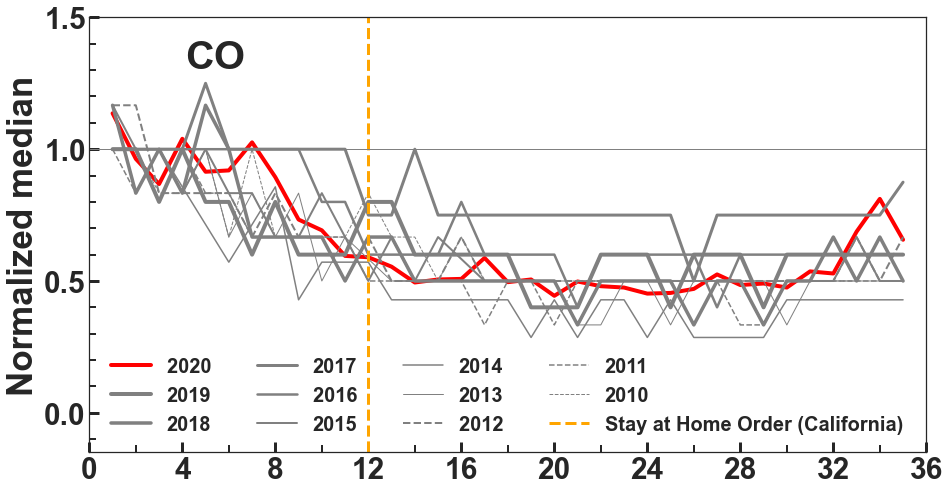

In [14]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
fig= plt.figure(figsize=(15, 8))
plt.style.use('seaborn-white')
ax=fig.add_subplot(111)
plt.plot(x ,qs,color='red', label='2020 ',linewidth=4)
plt.plot(x,qss , color='grey',label='2019', linewidth=4)
plt.plot(x,qsss , color='grey', label='2018',linewidth=3.5)
plt.plot(x,qssss , color='grey', label='2017',linewidth=3)
plt.plot(x ,qq,color='grey', label='2016 ',linewidth=2.5)
plt.plot(x,qqq , color='grey',label='2015', linewidth=2)
plt.plot(x,qqqq , color='grey', label='2014',linewidth=1.5)
plt.plot(x,qqqqq , color='grey', label='2013',linewidth=1)
plt.plot(x ,qz,color='grey', label='2012 ',linewidth=2,linestyle='dashed')
plt.plot(x,qzz , color='grey',label='2011', linewidth=1.5,linestyle='dashed')
plt.plot(x,qzzz , color='grey', label='2010',linewidth=1,linestyle='dashed')


plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.ylim(-0.15,1.5)
plt.xlim(0,we+1)
plt.axvline(x=12, color='orange', label='Stay at Home Order (California) ',linestyle='dashed',linewidth=3)
    #plt.axvspan('Week12', 'Week16', alpha=0.1, color='orange',label="Lockdown")
    #plt.xticks(1)
plt.axhline(y=1, color='grey',linewidth=1)
#plt.xticks(np.arange(0, max(x)+1, 2.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#plt.xlabel('Week',fontsize='35',fontweight='bold')
plt.ylabel('Normalized median',fontsize='35',fontweight='bold')

ax.tick_params(axis='y', which='minor', bottom=True,direction='in',length=7, width=2)
ax.tick_params(axis='y', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='minor', bottom=True,direction='in',length=7, width=2)
#plt.ylabel('Median PM2.5 during weeks / Median PM 2.5 in January',fontsize='14', fontweight='bold')
plt.legend(loc='lower right',fontsize='20',frameon=False,ncol=4)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                     label.set_fontname('Arial')
                     label.set_fontsize(30)
                     label.set_fontweight('bold')
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.rcParams["font.size"] = "20"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "20"
plt.title('CO',fontsize='40',fontweight='bold',x=0.15,y=0.87)
plt.savefig('CO normalized to Jan.png', bbox_inches='tight')

In [15]:
#Starting IDW
k1=pd.DataFrame(idw5)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted5)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted5=pd.DataFrame(adjusted5)
adjusted5.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [17]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [18]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope5[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            






In [16]:
#Finding D value from IDW


#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/COO.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       site=list(monitor['name'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
          start_d = pd.to_datetime(start) + datetime.timedelta(j)
          end_d = start_d + datetime.timedelta(7)
         
          week=monitor[monitor['Date']>=start_d]
          week=week[week['Date']<end_d]
            
           #Week 
          if len(week)>0: 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['County'],axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


                  
                  #10 year median 
           Med=np.nanmedian(five_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(histfive.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT2=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [17]:
#Concat both outputs
MapData=pd.concat([DF5,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [18]:
MapData = MapData.replace(-np.inf, np.nan)
MapData = MapData.replace(np.inf, np.nan)
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/ CO 5 year non aggregated.csv", index = False)



In [19]:
Dta['ID'].nunique()

77